# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)   
4 - [Exploratory Data Analysis](#eda)   
&emsp;  4.1 - [Data Cleaning: Deduplication](#deduplication)   
5 - [Text Preprocessing Using NLTK](#textprep)  
6 - [Train and Test Split of Data](#split)  
7 - [Logistic Regression Model](#lr)  
&emsp;  7.1 - [Function to find the optimal hyperparameter(C = 1/λ) and error using K-fold cross-validation](#bestC)  
&emsp;  7.2 - [Function to predict on Test Data](#acc)  
&emsp;  7.3 - [Function to check the behaviour of sparsity on weight vectors on increasing C= 1/λ in L1 regularization](#sparse)  
&emsp;  7.4 - [Multicollinearity Check (Pertubation Test)](#pert)  
&emsp;  7.5 - [Feature Importance](#fi)  
8 - [Featurization Methods](#vec)  
&emsp;  8.1 - [Bag Of Words(unigram)](#bowuni)   
&emsp;  8.2 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  8.3 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  8.4 - [TF-IDF(bigram)](#tfidfbi)   
&emsp;  8.5 - [Average Word2Vec](#avgw2v)  
&emsp;  8.6 - [TF-IDF Weighted Word2Vec](#tfidfw2v)  
9 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

-  Time Based slicing to split Train Data(70%) and Test Data(30%).
-  Appling Logistic Regression model to find the optimal hyperparameter(lambda) using 10 fold Cross Validation(both GridSearch and RandomSearch) in :  
&emsp; 1)Bag Of Words  
&emsp; 2)TF-IDF  
&emsp; 2)Average Word2Vec  
&emsp; 2)TF-IDF weighted Word2Vec 
-  Adding regularization(L1 and L2) to our logistic model.     
-  Checking the Accuracy and Sparsity of optimal weight vectors by increasing the value of lambda in L1 Regularization.    
-  Checking the Multicollinearity in weight vectors and finding the feature Importance.

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from collections import OrderedDict


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b


In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
}
</style>

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [7]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [8]:
print("Number of datapoints: ",filtered_data.shape[0])
print("Number of attributes/features: ",filtered_data.shape[1])
HTML(filtered_data.head().to_html(index=False))

Number of datapoints:  525814
Number of attributes/features:  10


Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [4] Exploratory Data Analysis :<a name="eda"></a>

### [4.1] Data Cleaning: Deduplication <a name="deduplication"></a>
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

<b>Deduplication 1:-</b> As can be seen below the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Deduplication 2:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


<b>Deduplication 3:-</b> It was also seen that a same user has given different reviews for a same product at same time.I think it is normal for a user to give multiple reviews about a product,but that should be in diffrent time.<br>
So,all those rows with same user giving multiple reviews for a same product at same time are considered as duplicate and hence dropped.

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId= "A8891HVRDJAM6" 
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86221,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",33,33,5,1161388800,Dog LOVE these!,We purchase these dinosaurs constantly. For s...
86236,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",3,3,5,1161388800,Very entertaining!,These dinos are great for powerful chewers! Ou...


In [15]:
final=final.drop_duplicates(subset={"ProductId","UserId","ProfileName","Time"}, keep='first', inplace=False)
print(final.shape)

(363633, 10)


<b>Deduplication 4:-</b> It was also seen that in few rows with Ids from 150493 to 150529 contain reviews regarding books,not fine foods.So I think these should be also removed from the dataset.
After looking at the productid column, it can be noticed that all the observations for fine foods start with B followed by numbers except for Ids from 150493 to 150529. 
I suppose the reviews for book ‘Chicken soup for the soul’ have gotten into the datset mistakenly as they contain the words “chicken soup.

In [16]:
display = final[final.ProductId == "0006641040"]
HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [17]:
final = final[final.ProductId != "0006641040"]

In [18]:
print("Percentage  of data still remaining : ",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of reviews left after Data Cleaning and Deduplication :")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Percentage  of data still remaining :  69.14973735959865
Number of reviews left after Data Cleaning and Deduplication :
(363599, 10)


positive    306566
negative     57033
Name: Score, dtype: int64

<b>Observation:-</b>  
It is an imbalanced dataset as the number of positive reviews are way high in number than negative reviews.

## [5] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

In [19]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.


### [5.1] Removal of html Tags :

In [20]:
#function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

cleanhtml("<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains")

' This is the only treat that is healthy and loved by all 4 legged beings in my home! It does not contain sugar or grains'

### [5.2] Removal of Punctuations and unecessary characters :

In [21]:
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#|@|~|%|*]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

cleanpunc("WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods?")

'WHYYYY do companies add sugar beet pulp or corn syrup to carnivore foods'

### [5.3] StopWords :

In [22]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
  
stop = set(stopwords.words('english')) #set of stopwords
print(stop)
print("*********************************************************************")
print("No. of stop words: ",len(stop))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'they', 'having', 'by', 'other', 'you', 'from', 'that', 'which', 'he', "needn't", 'shan', "mightn't", 'd', 'me', 'wouldn', 'has', 'yourselves', 'here', 'both', "shan't", "doesn't", 'can', 'is', 'ain', 'into', 'or', 'same', 't', 'again', "you're", 'are', 'mustn', 'under', 'further', 'hers', 'as', 'himself', "hadn't", 'few', 'have', 'below', 'hasn', 'off', 'until', 'my', 'she', 's', 'should', 'once', 'its', 'nor', 'where', 'haven', 'more', 'how', 'too', 'just', 'were', "don't", 'of', "hasn't", 'before', "couldn't", 'm', "shouldn't", 'not', 'hadn', 'her', 'ourselves', "it's", 'our', 'but', 'after', 'did', "haven't", 'herself', 'am', 'themselves', 'be', 'a', "wasn't", 'ma', "weren't", 'own', 'these', 'yours', 'wasn', 'itself', 'an', 'your', 'shouldn', 'weren', '

In [23]:
exceptions = ["aren't","mightn","wasn","hadn","don't","against","hadn't","shan","weren't","didn","don","hasn't", \
              "hasn","shouldn","didn't","wouldn","wasn't","needn't","shouldn't","wouldn't","aren","isn't","doesn't", \
              "nor","not","needn","couldn't","mightn't","mustn","mustn't","ain","shan't","haven","won't","couldn","isn", \
              "weren","haven't","no","haven't"]
new_stop = []
for i in stop:
    if i not in exceptions:
        new_stop.append(i)


print("No. of stop words after removing exceptions: ",len(new_stop))

No. of stop words after removing exceptions:  140


### [5.4] Stemming :

In [24]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

print("Orginal word: beautiful" + "|" +  "Stem word: " + sno.stem('beautiful'))
print("Orginal word: beauty" + "|" +  "Stem word: " + sno.stem('beauty'))
print("Orginal word: loved" + "|" +  "Stem word: " + sno.stem('loved'))
print("Orginal word: loving" + "|" +  "Stem word: " + sno.stem('loving'))

Orginal word: beautiful|Stem word: beauti
Orginal word: beauty|Stem word: beauti
Orginal word: loved|Stem word: love
Orginal word: loving|Stem word: love


<b>Observation:-</b>  
We can see words like "beautiful" and "beauty" have their stem as "beauti","loved" and "loving" have their stem as "love".  
Hence it helps in reducing the dimensions by taking the root stem of words.

### [5.5] Implementing the preprocessing steps one by one on all the<br>reviews of dataset :

In [22]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in new_stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [23]:
from nltk.probability import FreqDist
pdist = FreqDist(all_positive_words)
top_positive = pdist.most_common(20)
print("Top 20 Positive words ocuring frequenty in reviews:")
top_positive

Top 20 Positive words ocuring frequenty in reviews:


[(b'not', 146568),
 (b'like', 139160),
 (b'tast', 128865),
 (b'good', 112601),
 (b'flavor', 109329),
 (b'love', 107172),
 (b'use', 103792),
 (b'great', 103670),
 (b'one', 96529),
 (b'product', 90912),
 (b'tri', 86683),
 (b'tea', 83699),
 (b'coffe', 78763),
 (b'make', 75004),
 (b'get', 71996),
 (b'food', 64539),
 (b'would', 55477),
 (b'time', 55184),
 (b'buy', 54137),
 (b'realli', 52657)]

In [24]:
ndist = FreqDist(all_negative_words)
top_negative = ndist.most_common(20)
print("Top 20 Negative words ocuring frequenty in reviews:")
top_negative

Top 20 Negative words ocuring frequenty in reviews:


[(b'not', 54325),
 (b'tast', 34534),
 (b'like', 32271),
 (b'product', 28181),
 (b'one', 20544),
 (b'flavor', 19520),
 (b'would', 17947),
 (b'tri', 17718),
 (b'use', 15280),
 (b'good', 15024),
 (b'coffe', 14700),
 (b'get', 13775),
 (b'buy', 13742),
 (b'order', 12862),
 (b'food', 12720),
 (b'dont', 11865),
 (b'tea', 11646),
 (b'even', 11068),
 (b'box', 10833),
 (b'amazon', 10067)]

### [5.6] Adding a new column of CleanedText which displays the data after<br>pre-processing of the review  :

In [27]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [26]:
final[['Text','CleanedText']].head(10)

,Text,CleanedText
476617,This product by Arche...,product archer farm b...
22621,Our dogs just love th...,dog love saw pet stor...
22620,My dogs loves this ch...,dog love chicken prod...
284375,This book is easy to ...,book easi read ingred...
157850,I have been feeding m...,feed greyhound treat ...
157849,This is one product t...,one product welsh ter...
157833,This is the ONLY dog ...,dog treat lhasa apso ...
157832,These liver treas are...,liver trea phenomen r...
157837,This was the only tre...,treat dog like obedi ...
157831,"No waste , even if sh...",wast even day goe hun...


### [5.7] Using SQLite Table to load data after preprocessing <br> of reviews  :

In [ ]:
# store final result into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [26]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [27]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [28]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

## [6] Train and Test Split of Data : <a name="split"></a>

<b>Sorting the data by Time :</b>

In [29]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
387,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
293,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
386,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
209,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
271,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


<b>Considering negative reviews to be 0 and positive reviews to be 1 :

In [31]:
def reviews(x):
    if x == "positive":
        return 1
    else:
        return 0

final['Score'] = final['Score'].map(reviews)
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
387,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
293,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
386,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
209,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
271,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


<b>Time Based Slicing :</b>  
-  Diving the data to Train set(first 70% ie older data) and Test  Set(last 30% ie recent data)

In [32]:
from sklearn.model_selection import train_test_split

X = final["CleanedText"].values
y = final["Score"].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False)

In [33]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (254519,)
Shape of y_train:  (254519,)
Shape of X_test:  (109080,)
Shape of y_test:  (109080,)


In [34]:
dumpfile(X,"X")
dumpfile(y,"y") 
dumpfile(X_train,"X_train")
dumpfile(y_train,"y_train")
dumpfile(X_test,"X_test")
dumpfile(y_test,"y_test")

In [4]:
X = loadfile("X")
y = loadfile("y")
X_train = loadfile("X_train")
y_train = loadfile("y_train")
X_test = loadfile("X_test")
y_test = loadfile("y_test")

## [7] Logistic Regression : <a name="lr"></a>

<b>Grid Search Crossvalidation:</b>  

### [7.1] Function to find the optimal hyperparameter(C = 1/λ) and error using K-fold cross-validation : <a name="bestC"></a>
-  Taking C between range 0.0001 and 1000.  
-  Performing 10 fold cross validation on Train Data  
-  Finding the optimal C  
-  Plotting between CV error/CV Accuracy and C(1/λ)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,auc
import warnings
warnings.filterwarnings('ignore')


def LR_gridTrain(X_train,y_train,penalty):
    
    
    C_values = [0.0001,0.001, 0.01, 0.1, 1, 5 , 10, 50, 100, 1000]
    param_grid = dict(C = C_values) 
    
    model = LogisticRegression(penalty = penalty)
    grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    grid_mean_scores = [i.mean_validation_score for i in grid.grid_scores_]
    
    #Misclassification error
    MSE = [1 - x for x in grid_mean_scores]
    
    #Finding the optimal K
    optimal_C = grid.best_params_
    
    best_accuracy = np.round(grid.best_score_ * 100,3)
    
    print("\n\033[1mOptimal C:\033[0m ", optimal_C)
    print("\n\033[1mCrossValidation Error:\033[0m {}".format(np.round(min(MSE),3)))
    print("\n\033[1mCrossValidation Accuracy:\033[0m {} %\n\n".format(best_accuracy))
    
    plt.figure(figsize=(20,6))
    plt.style.use('fivethirtyeight')
    plt.subplot(121)
    plt.plot(C_values,MSE, 'r-o')
    for xy in zip(C_values, np.round(MSE,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Error vs C = 1/λ ")
    plt.xlabel("C = 1/λ")
    plt.ylabel("CV Error")
    plt.grid(True)

    plt.subplot(122)
    plt.plot(C_values,grid_mean_scores, 'g-o')
    for xy in zip(C_values, np.round(grid_mean_scores,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Accuracy vs C = 1/λ")
    plt.xlabel("C = 1/λ")
    plt.ylabel("CV Accuracy")
    plt.grid(True)
    plt.show()
    
    
    print("\n\033[1mCV Error for each value of C:\033[0m ",np.round(MSE,3))
    print("\n\033[1mCV Accuracy for each value of C:\033[0m ",np.round(grid_mean_scores,3))

<b>RandomSearch Crossvalidation:</b> To find a better hyperparameter value in fewer number of experiments.
Here the hyperparameter (C = 1/λ) is defined as a distribution rather than list of values.Here ,I use <b>exponential distribution</b>.

In [6]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon
import warnings
warnings.filterwarnings('ignore')

def LR_randomTrain(X_train,y_train,penalty):
    
    
    C_dist = expon(scale = 2)
    param_grid = dict(C = C_dist)
    
    model = LogisticRegression(penalty = penalty)
    random_grid = RandomizedSearchCV(model, param_grid, cv=10, scoring='accuracy')
    random_grid.fit(X_train, y_train)
    
    #Finding the optimal K
    optimal_C = random_grid.best_params_
    
    #Cv Accuracy
    best_accuracy = np.round(random_grid.best_score_ * 100,3)
    
    #Cv Error
    MSE = np.round((1 -random_grid.best_score_),3)
    
    
    print("\n\033[1mOptimal C:\033[0m ", optimal_C)
    print("\n\033[1mCrossValidation Error:\033[0m {}".format(MSE))
    print("\n\033[1mCrossValidation Accuracy:\033[0m {} %\n\n".format(best_accuracy))

### [7.2] Function to predict on Test Data : <a name="acc"></a>
-  Plotting the Confusion matrix  
-  Plotting the ROC/AUC Curve
-  Finding Acurracy,Precission,Recall and F1 Score on Test Data


<b>True Negative :</b> Number of datapoints with class label "negative" correctly classified as "negative".   
<b>False Positive :</b> Number of datapoints with class label "negative" misclassified as "positive".  
<b>False Negative :</b> Number of datapoints with class label "positive" misclassified as "negative".  
<b>True Positive:</b> Number of datapoints with class label "positive" correctly classified as "positive".  
<b>Precision :</b> True Positive/(True Positive + False Positive)  
<b>Recall :</b> True Positive/(True Positive + False Negative)

In [7]:
def LR_Test(X_train,X_test,y_train,y_test,penalty,optimal_C):

    optimal_model = LogisticRegression(C = optimal_C, penalty = penalty)
    optimal_model.fit(X_train, y_train)
    y_pred = optimal_model.predict(X_test)
    
    
    ##--------------Confusion Matrix and Performance metrics--------------##
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'macro')
    recall = recall_score(y_test,y_pred,average= 'macro')
    f1= f1_score(y_test,y_pred,average= 'macro')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))
    
    print("\n\n")
    
    ##--------------ROC Curve--------------##
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr,tpr)
    
    plt.figure(figsize=(8,6))
    plt.style.use('fivethirtyeight')
    plt.plot(fpr,tpr,'b',label="AUC = {}".format(roc_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("Receiver Operating Characteristic")
    plt.legend()
    plt.grid(True)
    plt.show()

### [7.3] Function to check the behaviour of sparsity on weight vectors on increasing C= 1/λ in L1 regularization : <a name="sparse"></a>

In [8]:
def sparsity_check(X_train,X_test,y_train,y_test):
    C_values = [10,1,0.1,0.01,0.001,0.0001]
    
    for i in C_values :
        start = time.clock()
        print("\n\033[1mSparsity and Accuarcy when C = {}\033[0m".format(i))
        model = LogisticRegression(penalty = 'l1',C = i)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test,y_pred) * 100
        train_error = 1 - model.score(X_train,y_train)
        test_error = 1 - model.score(X_test,y_test)
        
        print("Number of non-zero weighhts: ",np.count_nonzero(model.coef_))
        print("Train Error: ",np.round(train_error,3))
        print("Test Error: ",np.round(test_error,3))
        print("Test Accuracy :",np.round(accuracy_score(y_test,y_pred),5))
        print("Run Time :{} sec".format(time.clock() - start))

### [7.4] Multicollinearity Check (Pertubation Test) : <a name="pert"></a>

-  Finding the weight vector with X_train
-  Adding a small random noise with X_train and finding the new weight vecor by fitting to logistic model
-  Setting a threshold of 30%,if the difference between orginal weight vector and new weight vector is more than 30%,then said to be multicollinear

In [9]:
from scipy.sparse import find

def multicollinear_check(X_train,X_test,y_train,y_test,optimal_C,threshold = 30):
    
    print("\033[1m-----------BEFORE PERTUBATION TEST------------\033[0m\n")
    
    
    model = LogisticRegression(C = optimal_C, penalty = 'l2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred) * 100    
    weights = model.coef_
    print("\033[1mSample Weights:\033[0m ",pd.DataFrame(weights))
    print("\033[1mSize of weight vector:\033[0m ",weights.size)
    print("\033[1mNon zero weights:\033[0m ",np.count_nonzero(model.coef_))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    
    
    #--------------------Adding a small random nosie(epsilon) to weight vector------------------#
    X_trainnew = X_train
    #contains the row indices, column indices and values of the nonzero matrixes
    row,column,values = find(X_trainnew) 
    
    np.random.seed(0)
    noise = np.random.normal(loc = 0, scale = 0.01, size = (find(X_trainnew)[0].size,)).astype(np.float16)
    X_trainnew[row,column] = noise + X_trainnew[row,column]


    print("\n\033[1m-----------AFTER PERTUBATION TEST------------\033[0m\n")
    
    
    model_new = LogisticRegression(C = optimal_C, penalty = 'l2')
    model_new.fit(X_trainnew, y_train)
    y_prednew = model_new.predict(X_test)
    accuracy_new = accuracy_score(y_test,y_prednew) * 100
    weights_new = model_new.coef_
    print("\033[1mSample Weights:\033[0m ",pd.DataFrame(weights_new))
    print("\033[1mSize of weight vector:\033[0m ",weights_new.size)
    print("\033[1mNon zero weights:\033[0m ",np.count_nonzero(model_new.coef_))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy_new,3)))
    
    
    weight_difference = abs((weights - weights_new)/weights) * 100
    total = (weight_difference > threshold).sum()
    print("\n\n\033[1mNumber of features with weights changing greater than 30% :\033[0m",total)
    print("\n\033[1mFollowing are the {} features that are multicollinear\033[0m".format(total))
    size = np.shape(weight_difference)[1]
    for i in range(size):
        if weight_difference[0][i] > threshold:
            print(i, end = ' ')

### [7.4] Feature Importance : <a name="fi"></a>
-  Only finding the important features for each class in BOW and TFIDF

In [10]:
def feature_imortance(X_train,X_test,y_train,y_test,optimal_C,vectorizer, n = 25):
    
    model = LogisticRegression(C = optimal_C, penalty = 'l2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #------------------Feature Importance-------------------------------#        
    class_labels = model.classes_
    feature_names = vectorizer.get_feature_names()
    top_negative = sorted(zip(model.coef_[0], feature_names))[:n]
    top_positive= sorted(zip(model.coef_[0], feature_names))[-n:]

    print("\n\n\033[1m------------Top {} Negative Words with high Importance------------\033[0m".format(n))
    neg_featureimp_df = pd.DataFrame(top_negative, columns=['Coeficient Factor','Features'])
    print(neg_featureimp_df.to_string(index=False))
    
    
    print("\n\033[1m------------Top {} Positive Words with high Importance------------\033[0m".format(n))
    pos_featureimp_df = pd.DataFrame(top_positive, columns=['Coeficient Factor','Features'],)
    print(pos_featureimp_df.to_string(index=False))

## [8] Featurization Methods : <a name="vec"></a>  

### [8.1] Bag Of Words(unigram) : <a name="bowuni"></a>

In [46]:
%%time
bow_unigram = CountVectorizer(min_df = 0.0005)
X_train_bowuni = bow_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowuni))
print("The shape of text BOW vectorizer: ", X_train_bowuni.get_shape())
print("Number of unique word: ", X_train_bowuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (254519, 3878)
Number of unique word:  3878
CPU times: user 11.6 s, sys: 32 ms, total: 11.6 s
Wall time: 11.6 s


In [47]:
%%time
X_test_bowuni = bow_unigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowuni.get_shape())
print("Number of unique word: ", X_test_bowuni.get_shape()[1])

The shape of text BOW vectorizer:  (109080, 3878)
Number of unique word:  3878
CPU times: user 5.53 s, sys: 4 ms, total: 5.54 s
Wall time: 5.54 s


In [48]:
dumpfile(X_train_bowuni,"X_train_bowuni")
dumpfile(X_test_bowuni,"X_test_bowuni")

In [11]:
X_train_bowuni = loadfile("X_train_bowuni")
X_test_bowuni = loadfile("X_test_bowuni")

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bowuni_std = sc.fit_transform(X_train_bowuni)

In [13]:
X_test_bowuni_std = sc.transform(X_test_bowuni)

In [14]:
print("Shape of Training Data: ",X_train_bowuni_std.shape)
print("Shape of Test Data: ",X_test_bowuni_std.shape)

Shape of Training Data:  (254519, 3878)
Shape of Test Data:  (109080, 3878)


### [8.1.1] Using GridSearch CV :
<b>L2 Regularization :</b>


Optimal C:  {'C': 0.001}

CrossValidation Error: 0.076

CrossValidation Accuracy: 92.384 %




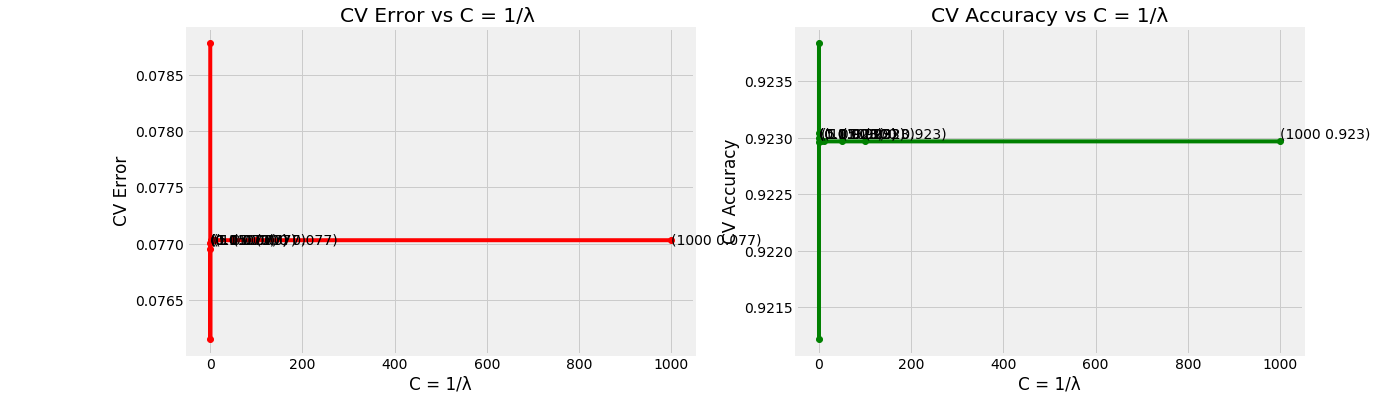


CV Error for each value of C:  [0.079 0.076 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077]

CV Accuracy for each value of C:  [0.921 0.924 0.923 0.923 0.923 0.923 0.923 0.923 0.923 0.923]
CPU times: user 9min 25s, sys: 2.56 s, total: 9min 27s
Wall time: 9min 27s


In [15]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_bowuni_std, y_train, penalty = 'l2')

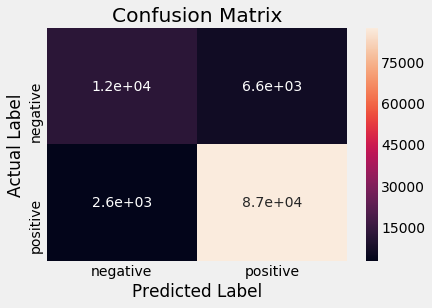

[[12473  6574]
 [ 2623 87410]]

Test Error : 0.084
Test Accuracy : 91.569 %
True Negative : 12473
False Positive : 6574
False Negative : 2623
True Positive : 87410
Precission Score : 0.878
Recall Score : 0.813
F1 Score : 0.84





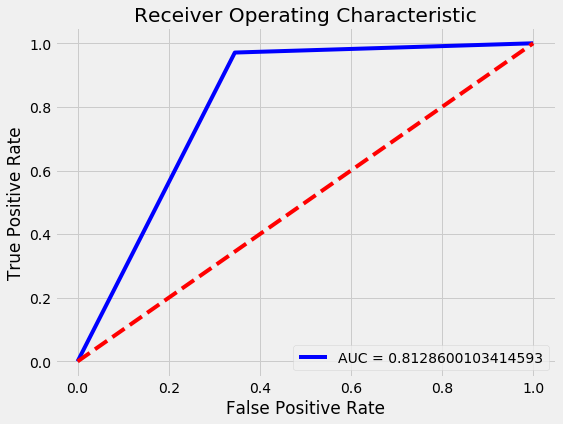

CPU times: user 3.68 s, sys: 8 ms, total: 3.69 s
Wall time: 3.33 s


In [78]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowuni_std, X_test_bowuni_std, y_train, y_test, 'l2', 0.001)

<b>L1 Regularization :</b>


Optimal C:  {'C': 0.1}

CrossValidation Error: 0.077

CrossValidation Accuracy: 92.325 %




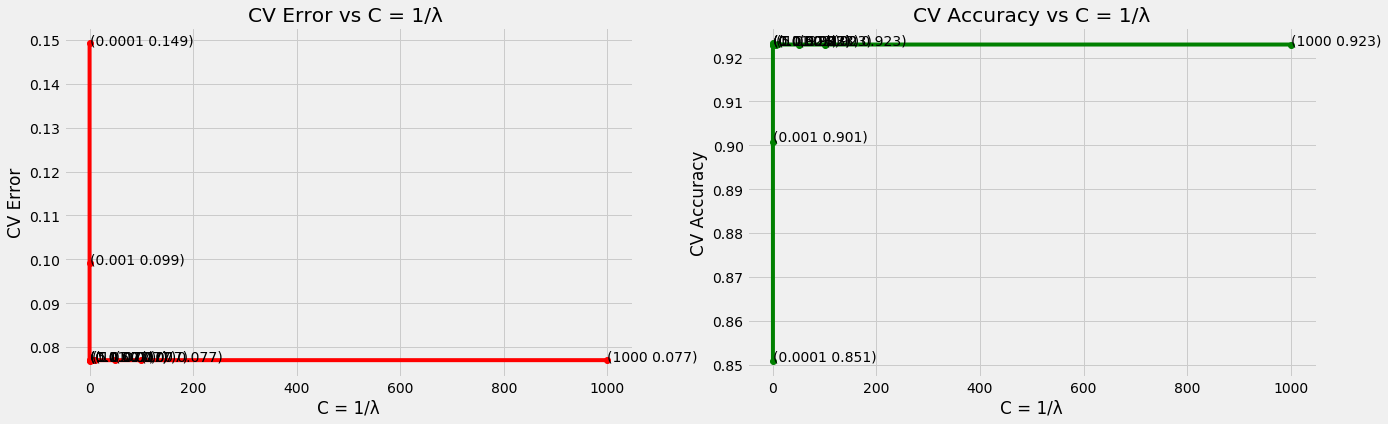


CV Error for each value of C:  [0.149 0.099 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077]

CV Accuracy for each value of C:  [0.851 0.901 0.923 0.923 0.923 0.923 0.923 0.923 0.923 0.923]
CPU times: user 3min 52s, sys: 2.01 s, total: 3min 54s
Wall time: 3min 54s


In [75]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_bowuni_std, y_train, penalty = 'l1')

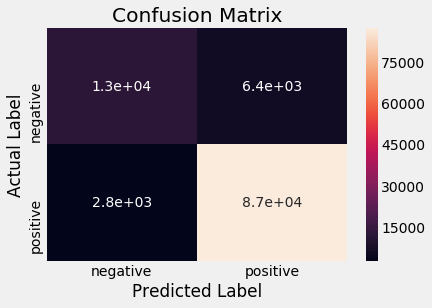

[[12611  6436]
 [ 2783 87250]]

Test Error : 0.085
Test Accuracy : 91.548 %
True Negative : 12611
False Positive : 6436
False Negative : 2783
True Positive : 87250
Precission Score : 0.875
Recall Score : 0.816
F1 Score : 0.841





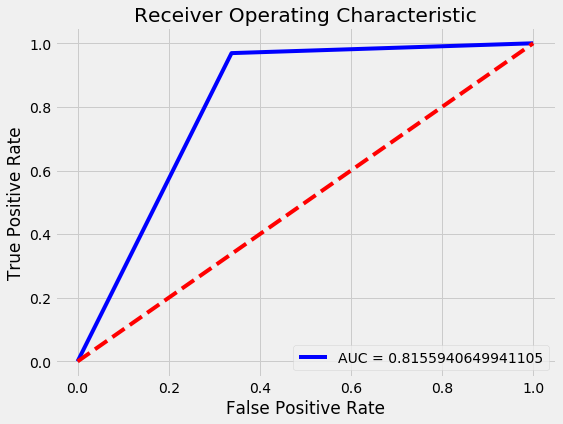

CPU times: user 3.9 s, sys: 28 ms, total: 3.92 s
Wall time: 3.61 s


In [79]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowuni_std, X_test_bowuni_std, y_train, y_test, 'l1', 0.1)

### [8.1.2] Sparsity And Accuracy on Weight Vectors(L1 Regularization) :

In [17]:
if __name__ == "__main__":
    sparsity_check(X_train_bowuni_std, X_test_bowuni_std ,y_train ,y_test)


Sparsity and Accuarcy when C = 10
Number of non-zero weighhts:  3876
Train Error:  0.069
Test Error:  0.084
Test Accuracy : 0.91569
Run Time :2.9262080000000004 sec

Sparsity and Accuarcy when C = 1
Number of non-zero weighhts:  3850
Train Error:  0.069
Test Error:  0.084
Test Accuracy : 0.91566
Run Time :2.668768 sec

Sparsity and Accuarcy when C = 0.1
Number of non-zero weighhts:  3714
Train Error:  0.069
Test Error:  0.085
Test Accuracy : 0.91547
Run Time :2.7338950000000004 sec

Sparsity and Accuarcy when C = 0.01
Number of non-zero weighhts:  2539
Train Error:  0.072
Test Error:  0.085
Test Accuracy : 0.91451
Run Time :2.7871330000000007 sec

Sparsity and Accuarcy when C = 0.001
Number of non-zero weighhts:  349
Train Error:  0.097
Test Error:  0.109
Test Accuracy : 0.891
Run Time :1.5401930000000004 sec

Sparsity and Accuarcy when C = 0.0001
Number of non-zero weighhts:  11
Train Error:  0.149
Test Error:  0.174
Test Accuracy : 0.82554
Run Time :1.144057 sec


<b>Observation :</b> Here C= 1/λ, we can see as C decreases(λ increases)
    -  Sparsity Increases(Number of non zero elements decreases)
    -  Error increases and Performance accuarcy drops(model starts underfitting)
    -  Run Time is also fast as sparsity increases

### [8.1.3] Using RandomSearch CV :
<b>L2 Regularization :</b>

In [96]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_bowuni_std, y_train, penalty = 'l2')


Optimal C:  {'C': 0.07806145232697875}

CrossValidation Error: 0.077

CrossValidation Accuracy: 92.299 %


CPU times: user 10min 47s, sys: 624 ms, total: 10min 48s
Wall time: 10min 48s


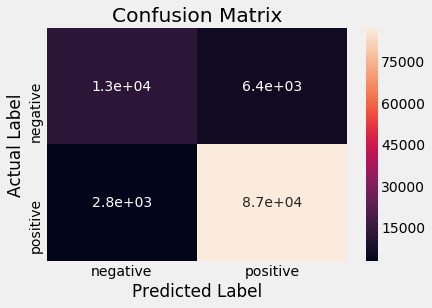

[[12692  6355]
 [ 2845 87188]]

Test Error : 0.084
Test Accuracy : 91.566 %
True Negative : 12692
False Positive : 6355
False Negative : 2845
True Positive : 87188
Precission Score : 0.874
Recall Score : 0.817
F1 Score : 0.842





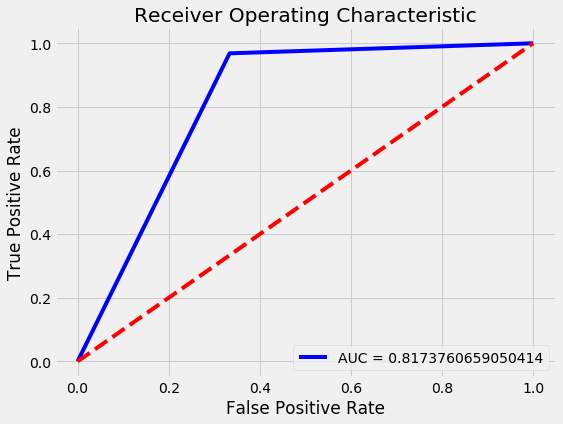

CPU times: user 5.82 s, sys: 12 ms, total: 5.83 s
Wall time: 5.46 s


In [97]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowuni_std, X_test_bowuni_std, y_train, y_test, 'l2', 0.078)

<b>L1 Regularization :</b>

In [94]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_bowuni_std, y_train, penalty = 'l1')


Optimal C:  {'C': 0.3521393406501542}

CrossValidation Error: 0.077

CrossValidation Accuracy: 92.3 %


CPU times: user 4min 31s, sys: 1.7 s, total: 4min 33s
Wall time: 4min 33s


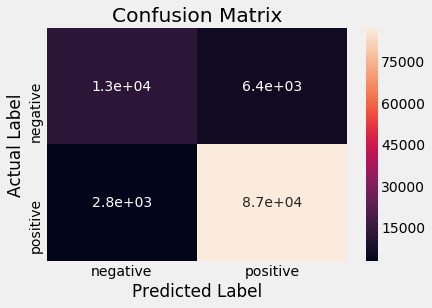

[[12670  6377]
 [ 2826 87207]]

Test Error : 0.084
Test Accuracy : 91.563 %
True Negative : 12670
False Positive : 6377
False Negative : 2826
True Positive : 87207
Precission Score : 0.875
Recall Score : 0.817
F1 Score : 0.842





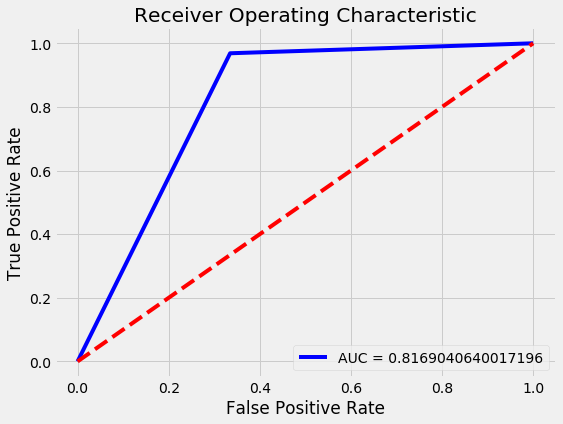

CPU times: user 3.96 s, sys: 40 ms, total: 4 s
Wall time: 3.67 s


In [95]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowuni_std, X_test_bowuni_std, y_train, y_test, 'l1', 0.352)

### [8.1.4] MultiCollinearity :

In [49]:
if __name__ == "__main__":
    multicollinear_check(X_train_bowuni_std,X_test_bowuni_std,y_train,y_test,0.001)

-----------BEFORE PERTUBATION TEST------------

Sample Weights:         0         1         2         3         4         5         6     \
0  0.000651  0.054345  0.037677  0.000138  0.004119 -0.008378  0.007636   

       7        8         9       ...         3868      3869      3870  \
0 -0.012763  0.01727  0.022878    ...     0.012175  0.011759  0.004692   

       3871      3872      3873      3874      3875      3876      3877  
0 -0.017501  0.013488  0.025814  0.025312  0.010537  0.016239 -0.002453  

[1 rows x 3878 columns]
Size of weight vector:  3878
Non zero weights:  3878
Test Accuracy : 91.574 %

-----------AFTER PERTUBATION TEST------------

Sample Weights:         0         1       2         3         4         5         6     \
0  0.000654  0.054352  0.0377  0.000136  0.004148 -0.008354  0.007643   

       7         8         9      ...         3868      3869      3870  \
0 -0.012724  0.017277  0.022884   ...     0.012187  0.011759  0.004678   

       3871      3872  

### [8.1.5] FeatureImportance :

In [53]:
if __name__ == "__main__":
    feature_imortance(X_train_bowuni_std,X_test_bowuni_std,y_train,y_test,0.001,bow_unigram)



------------Top 25 Negative Words with high Importance------------
Coeficient Factor    Features
        -0.426936         not
        -0.281176  disappoint
        -0.209263       worst
        -0.171752          aw
        -0.171402     terribl
        -0.161840     horribl
        -0.157774        tast
        -0.157565      return
        -0.147626       money
        -0.144013    unfortun
        -0.136553     thought
        -0.132869       stale
        -0.129352       would
        -0.128290       bland
        -0.125914       threw
        -0.121448       didnt
        -0.121260        wast
        -0.118510        even
        -0.112495        weak
        -0.112317         bad
        -0.110978        mayb
        -0.110584        noth
        -0.110162        hope
        -0.108740     product
        -0.106904        yuck

------------Top 25 Positive Words with high Importance------------
Coeficient Factor Features
         0.148925     keep
         0.153824  satisfi
  

### [8.2] Bag Of Words(bigram) : <a name="bowbi"></a>

In [13]:
%%time
bow_bigram = CountVectorizer(dtype='float', ngram_range=(1, 2), min_df = 0.0005)
X_train_bowbi = bow_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowbi))
print("The shape of text BOW vectorizer: ", X_train_bowbi.get_shape())
print("Number of unique word: ", X_train_bowbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (254519, 10711)
Number of unique word:  10711
CPU times: user 38.4 s, sys: 444 ms, total: 38.8 s
Wall time: 38.8 s


In [14]:
%%time
X_test_bowbi = bow_bigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowbi.get_shape())
print("Number of unique word: ", X_test_bowbi.get_shape()[1])

The shape of text BOW vectorizer:  (109080, 10711)
Number of unique word:  10711
CPU times: user 11.3 s, sys: 36 ms, total: 11.4 s
Wall time: 11.4 s


In [15]:
dumpfile(X_train_bowbi,"X_train_bowbi")
dumpfile(X_test_bowbi,"X_test_bowbi")

In [137]:
X_train_bowbi = loadfile("X_train_bowbi")
X_test_bowbi = loadfile("X_test_bowbi")

In [138]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bowbi_std = sc.fit_transform(X_train_bowbi)

In [139]:
X_test_bowbi_std = sc.transform(X_test_bowbi)

In [140]:
print("Shape of Training Data: ",X_train_bowbi_std.shape)
print("Shape of Test Data: ",X_test_bowbi_std.shape)

Shape of Training Data:  (254519, 10711)
Shape of Test Data:  (109080, 10711)


### [8.2.1] Using GridSearch CV :
<b>L2 Regularization :</b>


Optimal C:  {'C': 0.0001}

CrossValidation Error: 0.064

CrossValidation Accuracy: 93.631 %




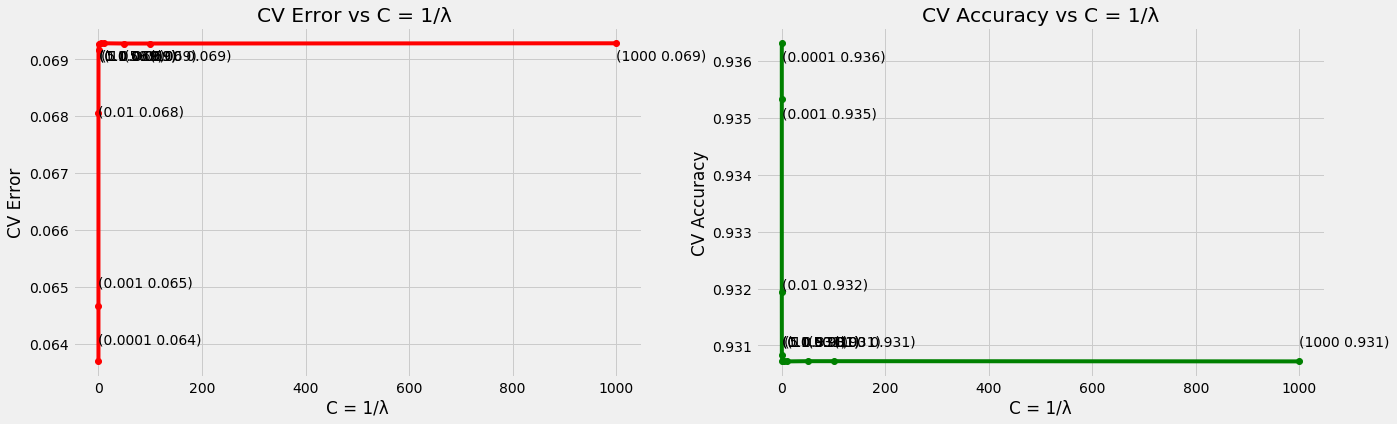


CV Error for each value of C:  [0.064 0.065 0.068 0.069 0.069 0.069 0.069 0.069 0.069 0.069]

CV Accuracy for each value of C:  [0.936 0.935 0.932 0.931 0.931 0.931 0.931 0.931 0.931 0.931]
CPU times: user 1h 8min 23s, sys: 35.5 s, total: 1h 8min 59s
Wall time: 31min


In [124]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_bowbi_std, y_train, penalty = 'l2')

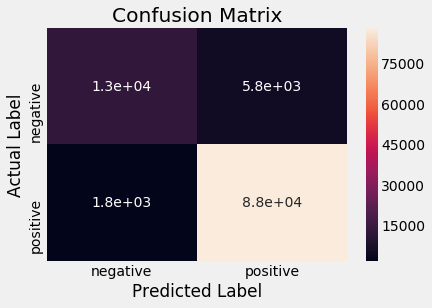

[[13262  5785]
 [ 1846 88187]]

Test Error : 0.07
Test Accuracy : 93.004 %
True Negative : 13262
False Positive : 5785
False Negative : 1846
True Positive : 88187
Precission Score : 0.908
Recall Score : 0.838
F1 Score : 0.868





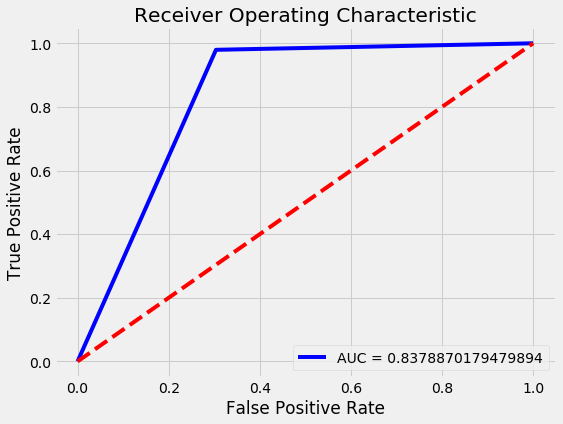

CPU times: user 7.15 s, sys: 48 ms, total: 7.2 s
Wall time: 3.9 s


In [126]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowbi_std, X_test_bowbi_std, y_train, y_test, 'l2', 0.0001)

<b>L1 Regularization :</b>


Optimal C:  {'C': 0.01}

CrossValidation Error: 0.065

CrossValidation Accuracy: 93.542 %




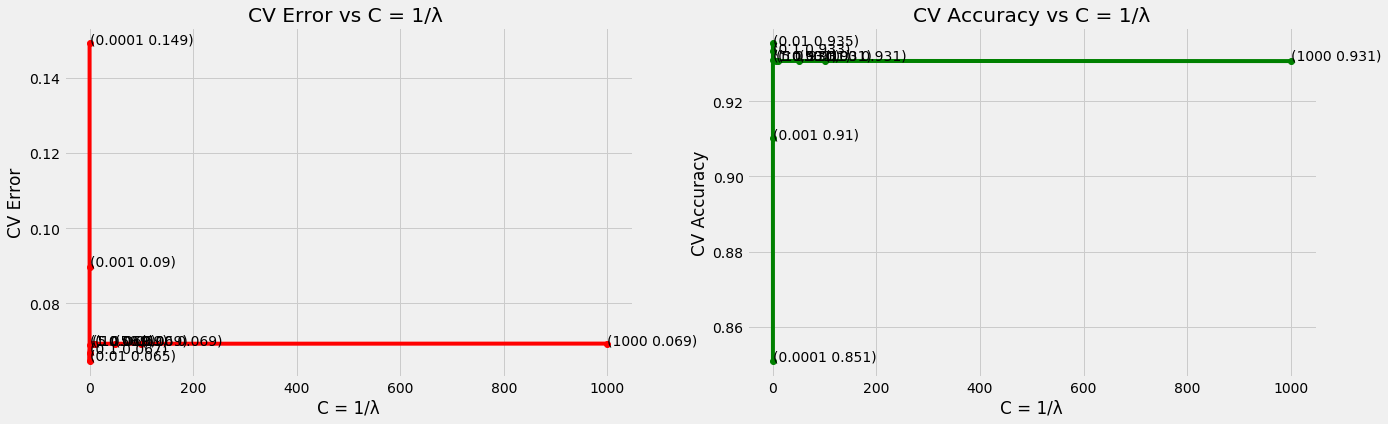


CV Error for each value of C:  [0.149 0.09  0.065 0.067 0.069 0.069 0.069 0.069 0.069 0.069]

CV Accuracy for each value of C:  [0.851 0.91  0.935 0.933 0.931 0.931 0.931 0.931 0.931 0.931]
CPU times: user 9min 59s, sys: 3.12 s, total: 10min 2s
Wall time: 10min 2s


In [128]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_bowbi_std, y_train, penalty = 'l1')

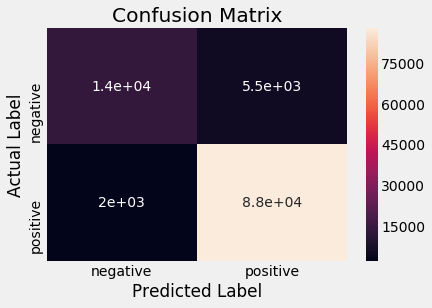

[[13501  5546]
 [ 2047 87986]]

Test Error : 0.07
Test Accuracy : 93.039 %
True Negative : 13501
False Positive : 5546
False Negative : 2047
True Positive : 87986
Precission Score : 0.905
Recall Score : 0.843
F1 Score : 0.87





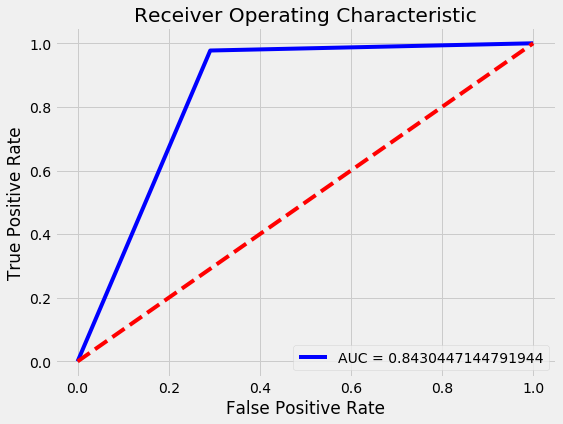

CPU times: user 4.68 s, sys: 48 ms, total: 4.73 s
Wall time: 4.39 s


In [130]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowbi_std, X_test_bowbi_std, y_train, y_test, 'l1', 0.01)

### [8.2.2] Sparsity And Accuracy on Weight Vectors(L1 Regularization) :

In [23]:
if __name__ == "__main__":
    sparsity_check(X_train_bowbi_std, X_test_bowbi_std ,y_train ,y_test)


Sparsity and Accuarcy when C = 10
Number of non-zero weighhts:  10700
Train Error:  0.046
Test Error:  0.072
Test Accuracy : 0.92789
Run Time :8.503957 sec

Sparsity and Accuarcy when C = 1
Number of non-zero weighhts:  10635
Train Error:  0.046
Test Error:  0.072
Test Accuracy : 0.92802
Run Time :8.91921 sec

Sparsity and Accuarcy when C = 0.1
Number of non-zero weighhts:  9917
Train Error:  0.047
Test Error:  0.07
Test Accuracy : 0.92952
Run Time :6.138832000000001 sec

Sparsity and Accuarcy when C = 0.01
Number of non-zero weighhts:  5251
Train Error:  0.055
Test Error:  0.07
Test Accuracy : 0.93036
Run Time :3.117297999999998 sec

Sparsity and Accuarcy when C = 0.001
Number of non-zero weighhts:  473
Train Error:  0.087
Test Error:  0.097
Test Accuracy : 0.90337
Run Time :1.7636930000000035 sec

Sparsity and Accuarcy when C = 0.0001
Number of non-zero weighhts:  12
Train Error:  0.149
Test Error:  0.174
Test Accuracy : 0.82583
Run Time :1.483823000000001 sec


<b>Observation :</b> Here C= 1/λ, we can see as C decreases(λ increases)
    -  Sparsity Increases(Number of non zero elements decreases)
    -  Error increases and Performance accuarcy drops(model starts underfitting)
    -  Run Time is also fast as sparsity increases

### [8.2.3] Using RandomSearch CV :
<b>L2 Regularization :</b>

In [129]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_bowbi_std, y_train, penalty = 'l2')


Optimal C:  {'C': 0.11828601922296544}

CrossValidation Error: 0.069

CrossValidation Accuracy: 93.079 %


CPU times: user 1h 28min 14s, sys: 39 s, total: 1h 28min 53s
Wall time: 39min 33s


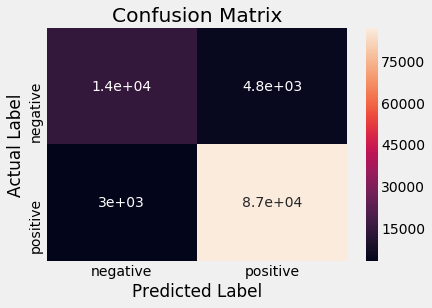

[[14218  4829]
 [ 3031 87002]]

Test Error : 0.072
Test Accuracy : 92.794 %
True Negative : 14218
False Positive : 4829
False Negative : 3031
True Positive : 87002
Precission Score : 0.886
Recall Score : 0.856
F1 Score : 0.87





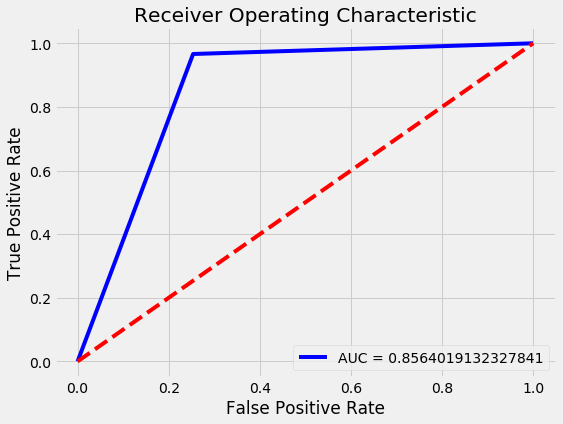

CPU times: user 35.4 s, sys: 228 ms, total: 35.6 s
Wall time: 17.4 s


In [131]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowbi_std, X_test_bowbi_std, y_train, y_test, 'l2', 0.118)

<b>L1 Regularization :</b>

In [132]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_bowbi_std, y_train, penalty = 'l1')


Optimal C:  {'C': 0.14447500879175584}

CrossValidation Error: 0.067

CrossValidation Accuracy: 93.257 %


CPU times: user 12min 6s, sys: 3.4 s, total: 12min 9s
Wall time: 12min 9s


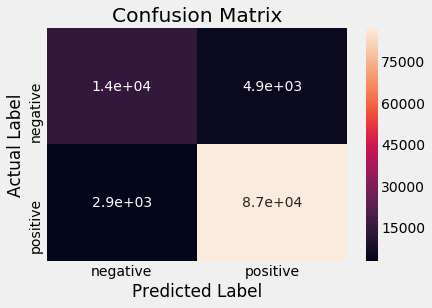

[[14179  4868]
 [ 2855 87178]]

Test Error : 0.071
Test Accuracy : 92.92 %
True Negative : 14179
False Positive : 4868
False Negative : 2855
True Positive : 87178
Precission Score : 0.89
Recall Score : 0.856
F1 Score : 0.872





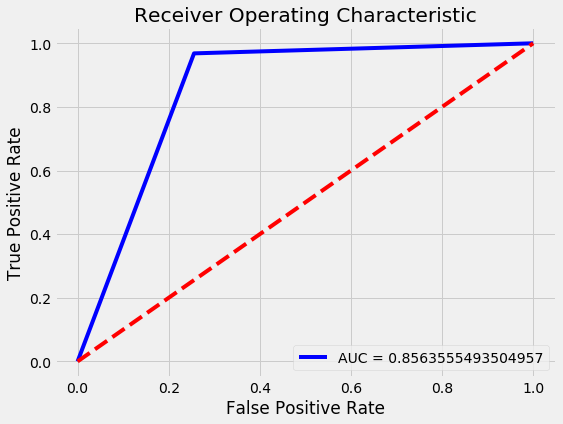

CPU times: user 7.41 s, sys: 48 ms, total: 7.46 s
Wall time: 7.09 s


In [133]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_bowbi_std, X_test_bowbi_std, y_train, y_test, 'l1', 0.144)

### [8.2.4] MultiCollinearity :

In [141]:
if __name__ == "__main__":
     multicollinear_check(X_train_bowbi_std, X_test_bowbi_std, y_train, y_test,0.0001)

-----------BEFORE PERTUBATION TEST------------

Sample Weights:        0        1         2         3         4         5         6      \
0  0.001976  0.02532  0.017236 -0.007174  0.000338  0.021763  0.011046   

      7         8         9        ...        10701     10702     10703  \
0 -0.003079  0.020889  0.013498    ...    -0.009104  0.006508  0.012586   

      10704    10705    10706     10707     10708     10709     10710  
0  0.015023  0.00658  0.00078  0.006959  0.006199  0.004551 -0.001347  

[1 rows x 10711 columns]
Size of weight vector:  10711
Non zero weights:  10711
Test Accuracy : 93.004 %

-----------AFTER PERTUBATION TEST------------

Sample Weights:        0         1         2         3         4         5         6      \
0  0.001975  0.025319  0.017242 -0.007172  0.000351  0.021761  0.011045   

      7         8         9        ...       10701     10702     10703  \
0 -0.003079  0.020887  0.013507    ...    -0.00911  0.006512  0.012584   

     10704     10705

### [8.2.5] FeatureImportance :

In [143]:
if __name__ == "__main__":
     feature_imortance(X_train_bowbi_std,X_test_bowbi_std,y_train,y_test,0.0001,bow_bigram)



------------Top 25 Negative Words with high Importance------------
Coeficient Factor       Features
        -0.187487     disappoint
        -0.112822          worst
        -0.106119      not worth
        -0.102862        not buy
        -0.097046       not good
        -0.094704  not recommend
        -0.094104             aw
        -0.092579        terribl
        -0.092061            not
        -0.087579        horribl
        -0.084748       unfortun
        -0.081491         return
        -0.078822       two star
        -0.077773          stale
        -0.076762       wont buy
        -0.073707          threw
        -0.073405          bland
        -0.072333           weak
        -0.072200     wast money
        -0.071753            bad
        -0.068186        disgust
        -0.067072           mayb
        -0.065819          sorri
        -0.062725      never buy
        -0.060210      tasteless

------------Top 25 Positive Words with high Importance------------
Coefi

### [8.3] TF-IDF(unigram) : <a name="tfidfuni"></a>

In [38]:
%%time
tfidf_unigram = TfidfVectorizer(dtype='float',min_df = 0.0005)
X_train_tfidfuni = tfidf_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfuni))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfuni.get_shape())
print("Number of unique word: ", X_train_tfidfuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (254519, 3878)
Number of unique word:  3878
CPU times: user 12 s, sys: 88 ms, total: 12.1 s
Wall time: 12.1 s


In [39]:
%%time
X_test_tfidfuni = tfidf_unigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfuni.get_shape())
print("Number of unique word: ", X_test_tfidfuni.get_shape()[1])

The shape of text TFIDF vectorizer:  (109080, 3878)
Number of unique word:  3878
CPU times: user 5.6 s, sys: 16 ms, total: 5.62 s
Wall time: 5.62 s


In [40]:
dumpfile(X_train_tfidfuni,"X_train_tfidfuni")
dumpfile(X_test_tfidfuni,"X_test_tfidfuni")

In [144]:
X_train_tfidfuni = loadfile("X_train_tfidfuni")
X_test_tfidfuni = loadfile("X_test_tfidfuni")

In [145]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfuni_std = sc.fit_transform(X_train_tfidfuni)

In [146]:
X_test_tfidfuni_std = sc.transform(X_test_tfidfuni)

In [147]:
print("Shape of Training Data: ",X_train_tfidfuni_std.shape)
print("Shape of Test Data: ",X_test_tfidfuni_std.shape)

Shape of Training Data:  (254519, 3878)
Shape of Test Data:  (109080, 3878)


### [8.3.1] Using GridSearch CV :
<b>L2 Regularization :</b>


Optimal C:  {'C': 0.001}

CrossValidation Error: 0.074

CrossValidation Accuracy: 92.617 %




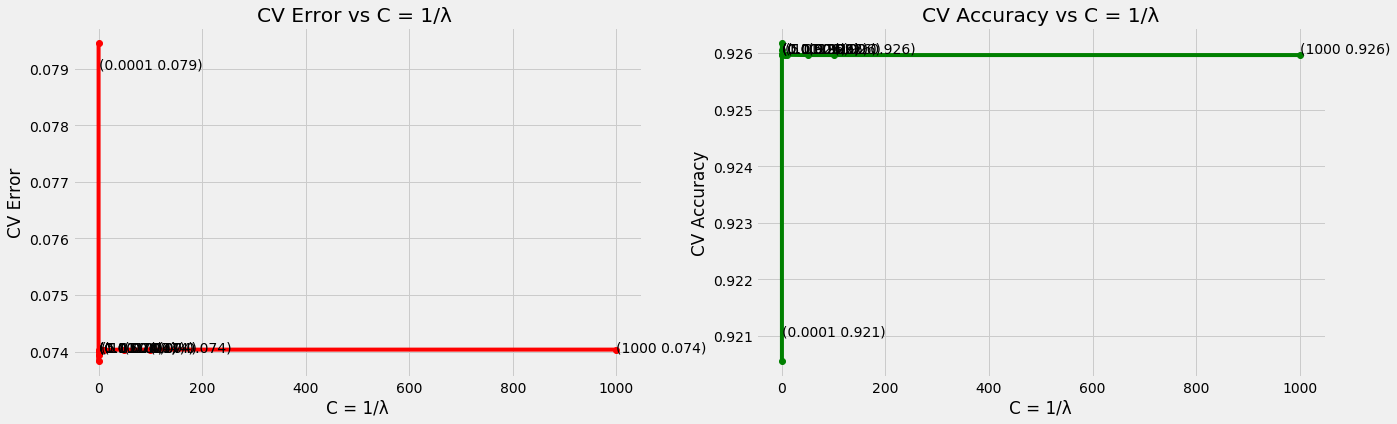


CV Error for each value of C:  [0.079 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074]

CV Accuracy for each value of C:  [0.921 0.926 0.926 0.926 0.926 0.926 0.926 0.926 0.926 0.926]
CPU times: user 6min 43s, sys: 436 ms, total: 6min 44s
Wall time: 6min 43s


In [141]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_tfidfuni_std, y_train, penalty = 'l2')

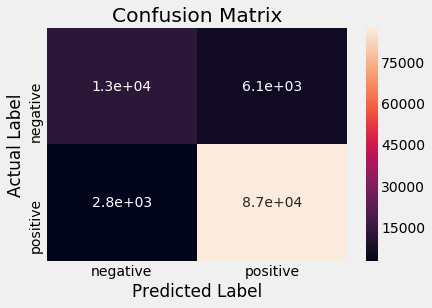

[[12913  6134]
 [ 2785 87248]]

Test Error : 0.082
Test Accuracy : 91.823 %
True Negative : 12913
False Positive : 6134
False Negative : 2785
True Positive : 87248
Precission Score : 0.878
Recall Score : 0.824
F1 Score : 0.847





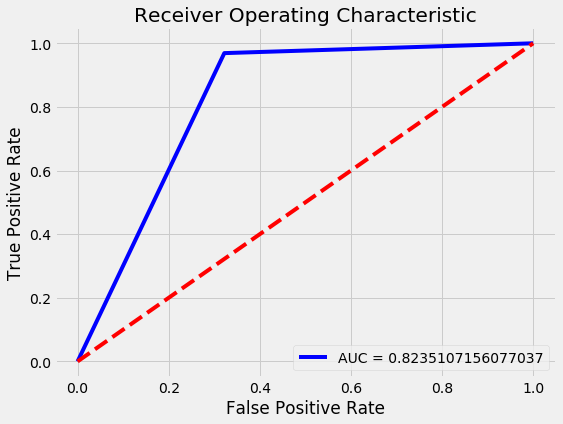

CPU times: user 3.66 s, sys: 4 ms, total: 3.66 s
Wall time: 3.3 s


In [145]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfuni_std, X_test_tfidfuni_std, y_train, y_test, 'l2', 0.001)

<b>L1 Regularization :</b>


Optimal C:  {'C': 0.1}

CrossValidation Error: 0.074

CrossValidation Accuracy: 92.619 %




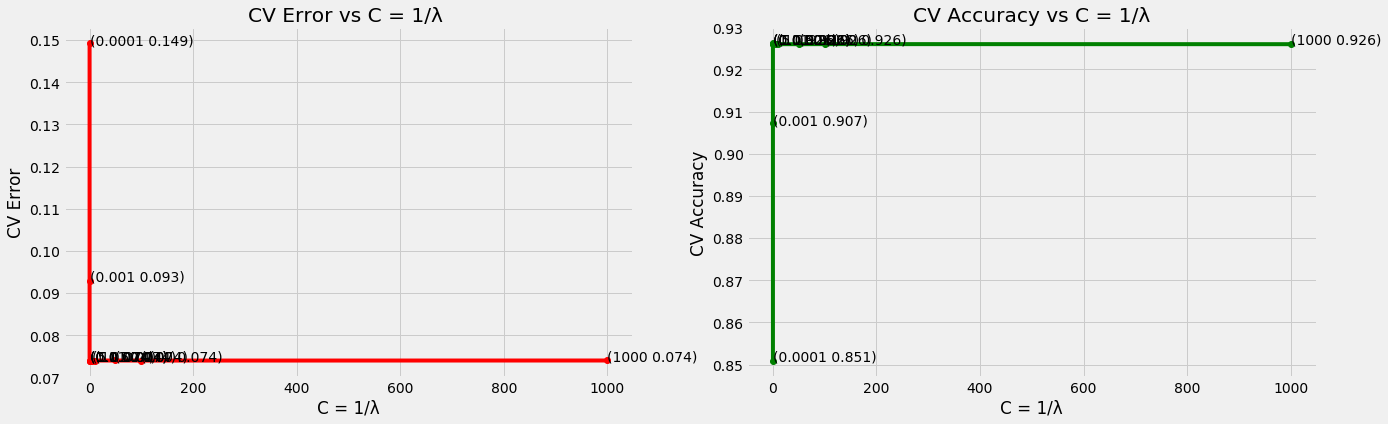


CV Error for each value of C:  [0.149 0.093 0.074 0.074 0.074 0.074 0.074 0.074 0.074 0.074]

CV Accuracy for each value of C:  [0.851 0.907 0.926 0.926 0.926 0.926 0.926 0.926 0.926 0.926]
CPU times: user 7min 48s, sys: 1.98 s, total: 7min 50s
Wall time: 7min 50s


In [142]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_tfidfuni_std, y_train, penalty = 'l1')

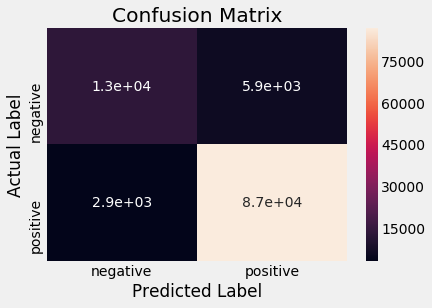

[[13120  5927]
 [ 2917 87116]]

Test Error : 0.081
Test Accuracy : 91.892 %
True Negative : 13120
False Positive : 5927
False Negative : 2917
True Positive : 87116
Precission Score : 0.877
Recall Score : 0.828
F1 Score : 0.85





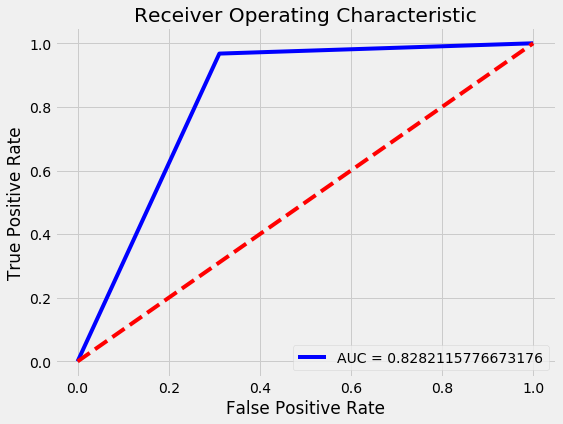

CPU times: user 7.09 s, sys: 20 ms, total: 7.11 s
Wall time: 6.72 s


In [144]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfuni_std, X_test_tfidfuni_std, y_train, y_test, 'l1', 0.1)

### [8.3.2] Sparsity And Accuracy on Weight Vectors(L1 Regularization) :

In [28]:
if __name__ == "__main__":
    sparsity_check(X_train_tfidfuni_std, X_test_tfidfuni_std ,y_train ,y_test)


Sparsity and Accuarcy when C = 10
Number of non-zero weighhts:  3875
Train Error:  0.066
Test Error:  0.081
Test Accuracy : 0.91856
Run Time :6.766615999999999 sec

Sparsity and Accuarcy when C = 1
Number of non-zero weighhts:  3853
Train Error:  0.066
Test Error:  0.081
Test Accuracy : 0.91868
Run Time :6.632743000000005 sec

Sparsity and Accuarcy when C = 0.1
Number of non-zero weighhts:  3747
Train Error:  0.066
Test Error:  0.081
Test Accuracy : 0.91891
Run Time :6.404086000000007 sec

Sparsity and Accuarcy when C = 0.01
Number of non-zero weighhts:  2682
Train Error:  0.068
Test Error:  0.081
Test Accuracy : 0.91913
Run Time :4.106678000000002 sec

Sparsity and Accuarcy when C = 0.001
Number of non-zero weighhts:  409
Train Error:  0.09
Test Error:  0.102
Test Accuracy : 0.89846
Run Time :2.20008 sec

Sparsity and Accuarcy when C = 0.0001
Number of non-zero weighhts:  12
Train Error:  0.149
Test Error:  0.174
Test Accuracy : 0.8256
Run Time :1.175690000000003 sec


<b>Observation :</b> Here C= 1/λ, we can see as C decreases(λ increases)
    -  Sparsity Increases(Number of non zero elements decreases)
    -  Error increases and Performance accuarcy drops(model starts underfitting)
    -  Run Time is also fast as sparsity increases

### [8.3.3] Using RandomSearch CV :
<b>L2 Regularization :</b>

In [146]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_tfidfuni_std, y_train, penalty = 'l2')


Optimal C:  {'C': 0.8189852652941816}

CrossValidation Error: 0.074

CrossValidation Accuracy: 92.598 %


CPU times: user 7min 51s, sys: 936 ms, total: 7min 52s
Wall time: 7min 52s


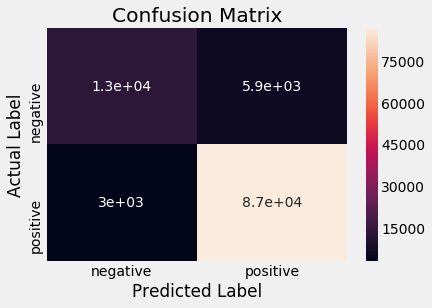

[[13140  5907]
 [ 2973 87060]]

Test Error : 0.081
Test Accuracy : 91.859 %
True Negative : 13140
False Positive : 5907
False Negative : 2973
True Positive : 87060
Precission Score : 0.876
Recall Score : 0.828
F1 Score : 0.849





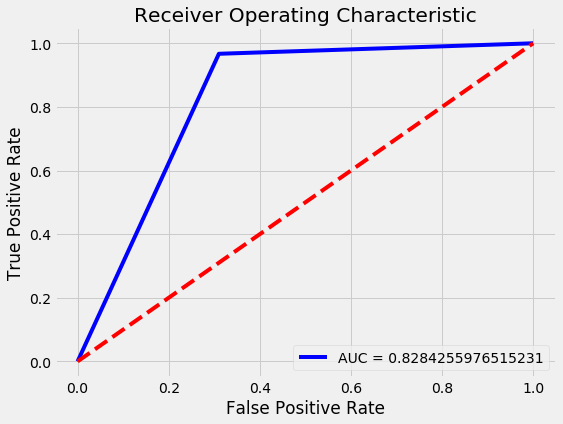

CPU times: user 6.42 s, sys: 32 ms, total: 6.45 s
Wall time: 6.1 s


In [148]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfuni_std, X_test_tfidfuni_std, y_train, y_test, 'l2', 0.818)

<b>L1 Regularization :</b>

In [147]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_tfidfuni_std, y_train, penalty = 'l1')


Optimal C:  {'C': 0.01676258606542679}

CrossValidation Error: 0.073

CrossValidation Accuracy: 92.681 %


CPU times: user 9min 15s, sys: 2.16 s, total: 9min 17s
Wall time: 9min 17s


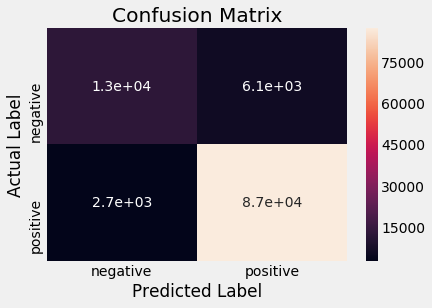

[[12930  6117]
 [ 2702 87331]]

Test Error : 0.081
Test Accuracy : 91.915 %
True Negative : 12930
False Positive : 6117
False Negative : 2702
True Positive : 87331
Precission Score : 0.881
Recall Score : 0.824
F1 Score : 0.849





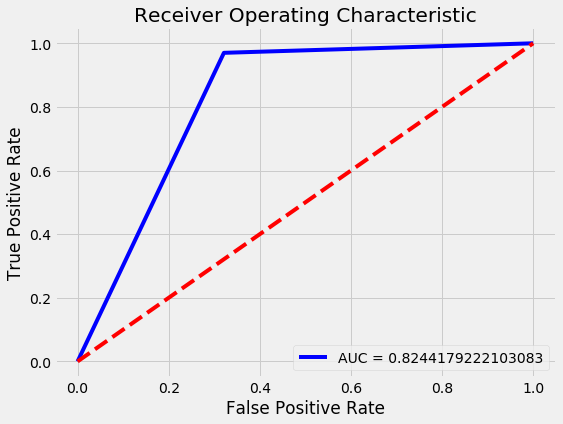

CPU times: user 6.04 s, sys: 28 ms, total: 6.06 s
Wall time: 5.69 s


In [149]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfuni_std, X_test_tfidfuni_std, y_train, y_test, 'l1', 0.016)

### [8.3.4] MultiCollinearity :

In [150]:
if __name__ == "__main__":
     multicollinear_check(X_train_tfidfuni_std, X_test_tfidfuni_std, y_train, y_test,0.001)

-----------BEFORE PERTUBATION TEST------------

Sample Weights:         0         1         2        3         4        5         6     \
0  0.006177  0.054816  0.039201  0.00835  0.005969 -0.00787  0.009118   

       7         8         9       ...         3868      3869      3870  \
0 -0.008688  0.008616  0.014231    ...     0.014822  0.010729  0.005334   

       3871      3872      3873      3874      3875      3876      3877  
0 -0.003729  0.006976  0.023702  0.023845  0.006898  0.018194 -0.002004  

[1 rows x 3878 columns]
Size of weight vector:  3878
Non zero weights:  3878
Test Accuracy : 91.825 %

-----------AFTER PERTUBATION TEST------------

Sample Weights:         0         1         2         3         4         5        6     \
0  0.006186  0.054843  0.039186  0.008354  0.005992 -0.007852  0.00912   

       7         8         9       ...         3868      3869      3870  \
0 -0.008659  0.008639  0.014248    ...     0.014836  0.010734  0.005318   

       3871      3872

### [8.3.5] FeatureImportance :

In [149]:
if __name__ == "__main__":
     feature_imortance(X_train_tfidfuni_std,X_test_tfidfuni_std,y_train,y_test,0.001,tfidf_unigram)



------------Top 25 Negative Words with high Importance------------
Coeficient Factor    Features
        -0.347543         not
        -0.242920  disappoint
        -0.209474       worst
        -0.162968          aw
        -0.156885     terribl
        -0.145698     horribl
        -0.143453      return
        -0.134956        tast
        -0.126144       threw
        -0.119785       money
        -0.119123    unfortun
        -0.116417       stale
        -0.112915       didnt
        -0.111654        wast
        -0.110265       bland
        -0.108177     thought
        -0.106271     disgust
        -0.103017        even
        -0.099548       would
        -0.098077        hope
        -0.097126        weak
        -0.094650        mayb
        -0.094515        noth
        -0.093463        yuck
        -0.091183   tasteless

------------Top 25 Positive Words with high Importance------------
Coeficient Factor Features
         0.156612  fantast
         0.160048     beat
  

### [8.4] TF-IDF(bigram) : <a name="tfidfbi"></a>

In [11]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2),min_df = 0.0005)
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfbi))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfbi.get_shape())
print("Number of unique word: ", X_train_tfidfbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (254519, 10711)
Number of unique word:  10711
CPU times: user 36.7 s, sys: 428 ms, total: 37.1 s
Wall time: 37.1 s


In [30]:
%%time
X_test_tfidfbi = tfidf_bigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfbi.get_shape())
print("Number of unique word: ", X_test_tfidfbi.get_shape()[1])

The shape of text TFIDF vectorizer:  (109080, 10711)
Number of unique word:  10711
CPU times: user 11.2 s, sys: 28 ms, total: 11.2 s
Wall time: 11.2 s


In [152]:
dumpfile(X_train_tfidfbi,"X_train_tfidfbi")
dumpfile(X_test_tfidfbi,"X_test_tfidfbi")

In [151]:
X_train_tfidfbi = loadfile("X_train_tfidfbi")
X_test_tfidfbi = loadfile("X_test_tfidfbi")

In [152]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfbi_std = sc.fit_transform(X_train_tfidfbi)

In [153]:
X_test_tfidfbi_std = sc.transform(X_test_tfidfbi)

In [154]:
print("Shape of Training Data: ",X_train_tfidfbi_std.shape)
print("Shape of Test Data: ",X_test_tfidfbi_std.shape)

Shape of Training Data:  (254519, 10711)
Shape of Test Data:  (109080, 10711)


### [8.4.1] Using GridSearch CV :
<b>L2 Regularization :</b>


Optimal C:  {'C': 0.001}

CrossValidation Error: 0.063

CrossValidation Accuracy: 93.67 %




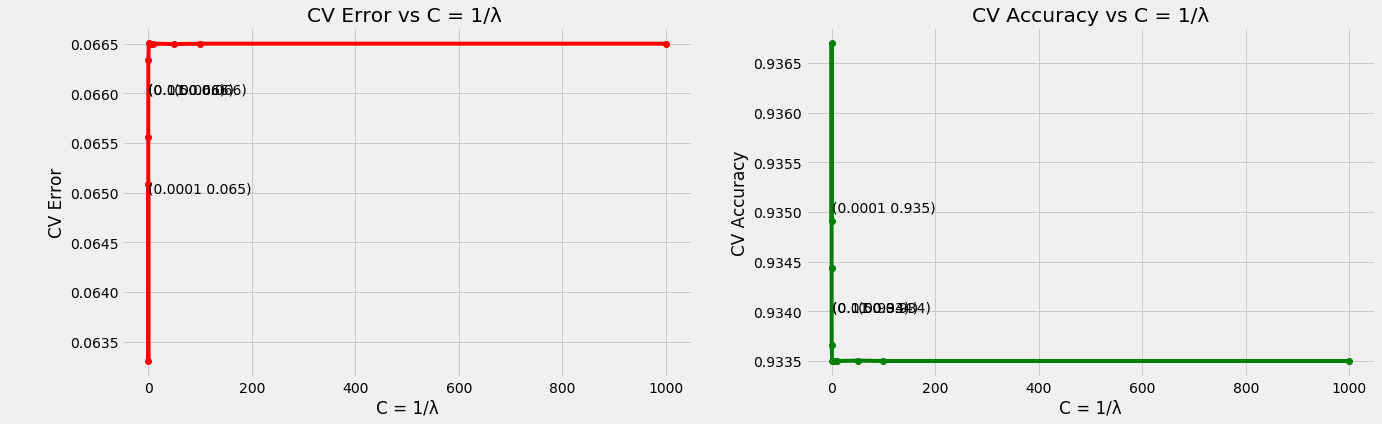


CV Error for each value of C:  [0.065 0.063 0.066 0.066 0.067 0.067 0.067 0.066 0.067 0.067]

CV Accuracy for each value of C:  [0.935 0.937 0.934 0.934 0.933 0.933 0.933 0.934 0.933 0.933]
CPU times: user 1h 7min 34s, sys: 30 s, total: 1h 8min 4s
Wall time: 31min 42s


In [157]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_tfidfbi_std, y_train, penalty = 'l2')

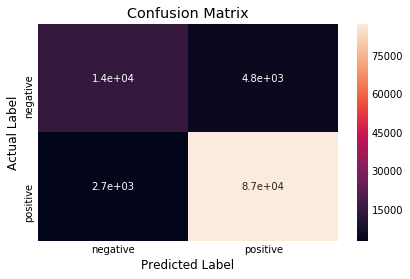

[[14255  4792]
 [ 2663 87370]]

Test Error : 0.068
Test Accuracy : 93.166 %
True Negative : 14255
False Positive : 4792
False Negative : 2663
True Positive : 87370
Precission Score : 0.895
Recall Score : 0.859
F1 Score : 0.876





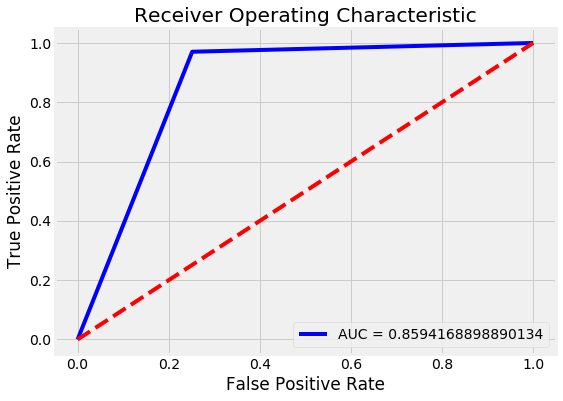

CPU times: user 11.6 s, sys: 104 ms, total: 11.7 s
Wall time: 6.09 s


In [171]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfbi_std, X_test_tfidfbi_std, y_train, y_test, 'l2', 0.001)

<b>L1 Regularization :</b>


Optimal C:  {'C': 0.01}

CrossValidation Error: 0.061

CrossValidation Accuracy: 93.89 %




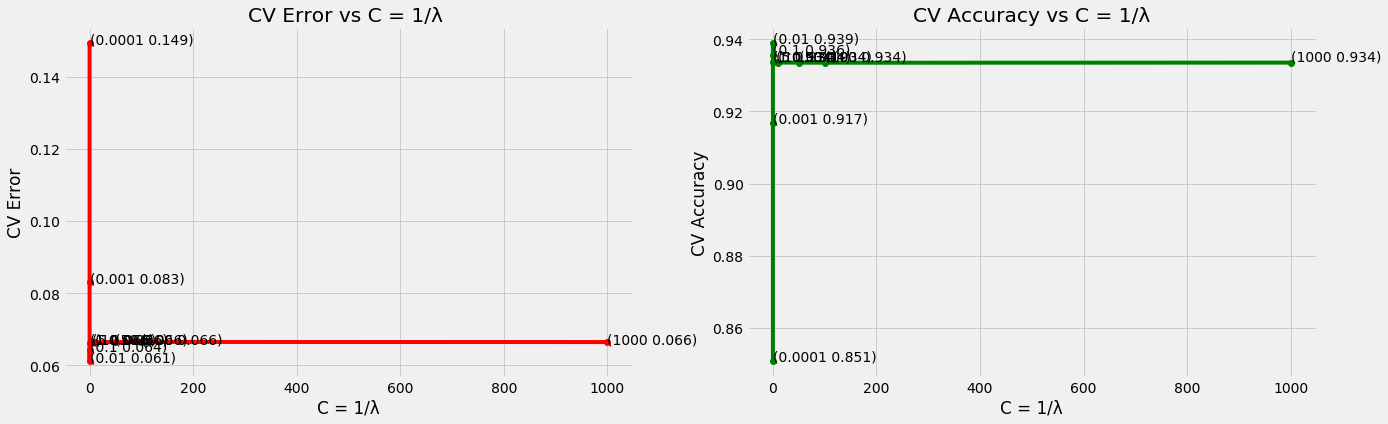


CV Error for each value of C:  [0.149 0.083 0.061 0.064 0.066 0.066 0.066 0.066 0.066 0.066]

CV Accuracy for each value of C:  [0.851 0.917 0.939 0.936 0.934 0.934 0.934 0.934 0.934 0.934]
CPU times: user 11min 36s, sys: 5.46 s, total: 11min 42s
Wall time: 11min 41s


In [158]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_tfidfbi_std, y_train, penalty = 'l1')

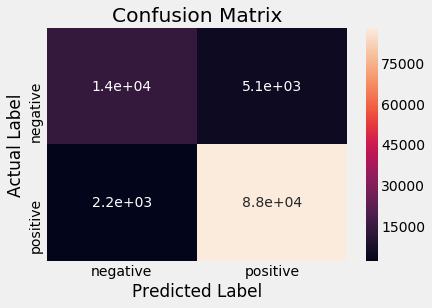

[[13968  5079]
 [ 2167 87866]]

Test Error : 0.066
Test Accuracy : 93.357 %
True Negative : 13968
False Positive : 5079
False Negative : 2167
True Positive : 87866
Precission Score : 0.906
Recall Score : 0.855
F1 Score : 0.877





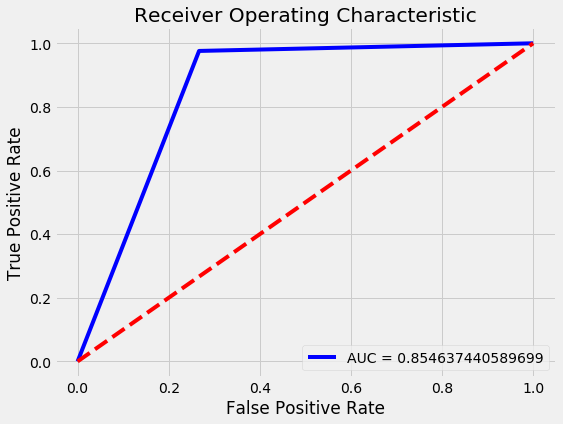

CPU times: user 6.5 s, sys: 48 ms, total: 6.54 s
Wall time: 6.14 s


In [172]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfbi_std, X_test_tfidfbi_std, y_train, y_test, 'l1', 0.01)

### [8.4.2] Sparsity And Accuracy on Weight Vectors(L1 Regularization) :

In [33]:
if __name__ == "__main__":
    sparsity_check(X_train_tfidfbi_std, X_test_tfidfbi_std ,y_train ,y_test)


Sparsity and Accuarcy when C = 10
Number of non-zero weighhts:  10698
Train Error:  0.045
Test Error:  0.07
Test Accuracy : 0.92995
Run Time :9.959680000000006 sec

Sparsity and Accuarcy when C = 1
Number of non-zero weighhts:  10608
Train Error:  0.045
Test Error:  0.07
Test Accuracy : 0.9301
Run Time :8.638589999999994 sec

Sparsity and Accuarcy when C = 0.1
Number of non-zero weighhts:  9956
Train Error:  0.046
Test Error:  0.069
Test Accuracy : 0.93129
Run Time :6.357533000000004 sec

Sparsity and Accuarcy when C = 0.01
Number of non-zero weighhts:  5396
Train Error:  0.052
Test Error:  0.066
Test Accuracy : 0.93356
Run Time :5.3310010000000005 sec

Sparsity and Accuarcy when C = 0.001
Number of non-zero weighhts:  539
Train Error:  0.08
Test Error:  0.089
Test Accuracy : 0.91087
Run Time :2.64649399999999 sec

Sparsity and Accuarcy when C = 0.0001
Number of non-zero weighhts:  14
Train Error:  0.149
Test Error:  0.174
Test Accuracy : 0.82603
Run Time :1.4733790000000084 sec


<b>Observation :</b> Here C= 1/λ, we can see as C decreases(λ increases)
    -  Sparsity Increases(Number of non zero elements decreases)
    -  Error increases and Performance accuarcy drops(model starts underfitting)
    -  Run Time is also fast as sparsity increases

### [8.4.3] Using RandomSearch CV :
<b>L2 Regularization :</b>

In [ ]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_tfidfbi_std, y_train, penalty = 'l2')


Optimal C:  {'C': 0.09716463627118838}

CrossValidation Error: 0.066

CrossValidation Accuracy: 93.366 %


CPU times: user 1h 24min 43s, sys: 35.6 s, total: 1h 25min 18s
Wall time: 39min 50s


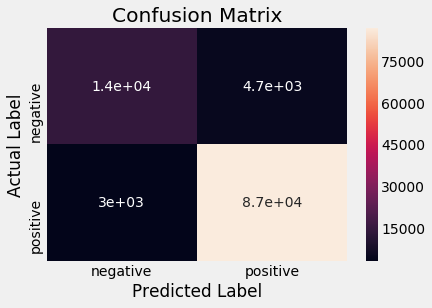

[[14387  4660]
 [ 2977 87056]]

Test Error : 0.07
Test Accuracy : 92.999 %
True Negative : 14387
False Positive : 4660
False Negative : 2977
True Positive : 87056
Precission Score : 0.889
Recall Score : 0.861
F1 Score : 0.874





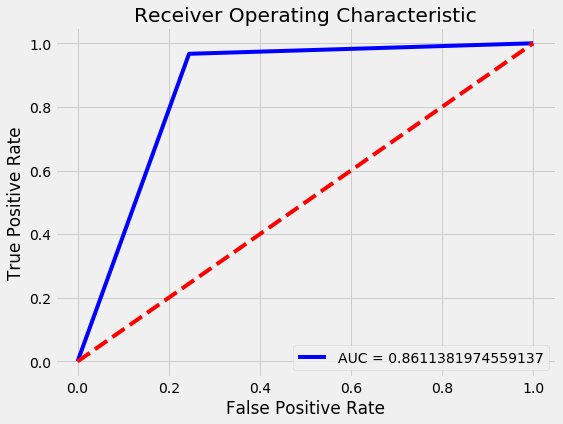

CPU times: user 30.9 s, sys: 200 ms, total: 31.1 s
Wall time: 15.5 s


In [36]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfbi_std, X_test_tfidfbi_std, y_train, y_test, 'l2',0.097)

<b>L1 Regularization :</b>

In [ ]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_tfidfbi_std, y_train, penalty = 'l1')


Optimal C:  {'C': 0.01845898506776376}

CrossValidation Error: 0.061

CrossValidation Accuracy: 93.904 %


CPU times: user 14min 6s, sys: 4.92 s, total: 14min 10s
Wall time: 14min 11s


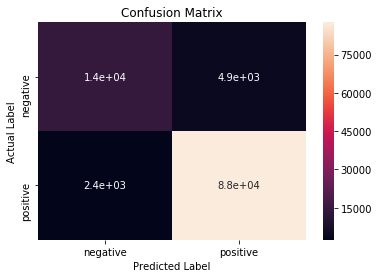

[[14190  4857]
 [ 2406 87627]]

Test Error : 0.067
Test Accuracy : 93.342 %
True Negative : 14190
False Positive : 4857
False Negative : 2406
True Positive : 87627
Precission Score : 0.901
Recall Score : 0.859
F1 Score : 0.878





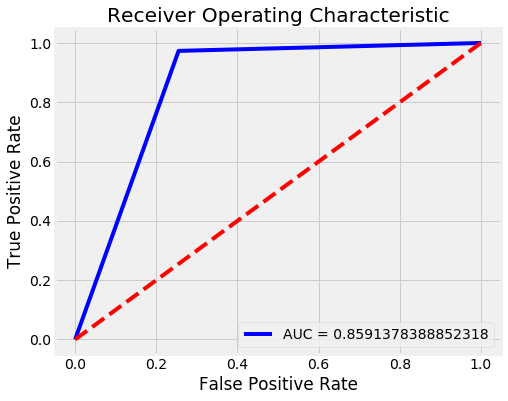

CPU times: user 7.26 s, sys: 44 ms, total: 7.31 s
Wall time: 7.02 s


In [34]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfbi_std, X_test_tfidfbi_std, y_train, y_test, 'l1', 0.018)

### [8.4.4] MultiCollinearity :

In [155]:
if __name__ == "__main__":
     multicollinear_check(X_train_tfidfbi_std, X_test_tfidfbi_std, y_train, y_test,0.001)

-----------BEFORE PERTUBATION TEST------------

Sample Weights:        0         1        2        3         4         5         6      \
0 -0.000201  0.039059  0.03512 -0.02023 -0.002252  0.035492  0.009385   

     7         8         9       ...        10701     10702     10703  \
0 -0.01361  0.039944  0.014182   ...    -0.000493  0.011343  0.026953   

      10704     10705     10706     10707     10708     10709    10710  
0  0.030759  0.008869 -0.010293  0.024731  0.012831  0.008689 -0.00666  

[1 rows x 10711 columns]
Size of weight vector:  10711
Non zero weights:  10711
Test Accuracy : 93.166 %

-----------AFTER PERTUBATION TEST------------

Sample Weights:        0         1         2         3         4         5         6      \
0 -0.000221  0.039054  0.035148 -0.020233 -0.002193  0.035475  0.009385   

      7         8         9        ...        10701    10702     10703  \
0 -0.013613  0.039935  0.014227    ...    -0.000511  0.01135  0.026948   

      10704     10705   

### [8.4.5] FeatureImportance :

In [156]:
if __name__ == "__main__":
     feature_imortance(X_train_tfidfbi_std,X_test_tfidfbi_std,y_train,y_test,0.001,tfidf_bigram)



------------Top 25 Negative Words with high Importance------------
Coeficient Factor       Features
        -0.309475     disappoint
        -0.190949            not
        -0.179745          worst
        -0.168787      not worth
        -0.154740       not good
        -0.147985             aw
        -0.147965  not recommend
        -0.147495       two star
        -0.147186        terribl
        -0.137424        not buy
        -0.135074        horribl
        -0.120756          stale
        -0.118112         return
        -0.116322          threw
        -0.116124       unfortun
        -0.112878           weak
        -0.111305       wont buy
        -0.111163            bad
        -0.110713          bland
        -0.106437     wast money
        -0.104984        disgust
        -0.092486           mayb
        -0.091960          sorri
        -0.090592           tast
        -0.090431      tasteless

------------Top 25 Positive Words with high Importance------------
Coefi

## [8.5] Average Word2Vec : <a name="avgw2v"></a>

In [13]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [14]:
print(X_train[5])
print("****************************************************************************")
print(list_of_sent_train[5])

bought apart infest fruit fli hour trap mani fli within day practic gone may not long term solut fli drive crazi consid buy one surfac sticki tri avoid touch
****************************************************************************
['bought', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'fli', 'within', 'day', 'practic', 'gone', 'may', 'not', 'long', 'term', 'solut', 'fli', 'drive', 'crazi', 'consid', 'buy', 'one', 'surfac', 'sticki', 'tri', 'avoid', 'touch']


In [15]:
%%time
## Word2Vec Model considering only those words that occur atleast 5 times in the corpus
min_count = 5
w2v_model = Word2Vec(list_of_sent_train, min_count = min_count, size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

CPU times: user 2min 8s, sys: 240 ms, total: 2min 9s
Wall time: 36 s


In [16]:
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [16]:
print(X_test[5])
print("****************************************************************************")
print(list_of_sent_test[5])

dog love love dog food say love twice dog food one dog favorit
****************************************************************************
['dog', 'love', 'love', 'dog', 'food', 'say', 'love', 'twice', 'dog', 'food', 'one', 'dog', 'favorit']


In [37]:
%%time
X_train_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train:
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)

CPU times: user 7min 47s, sys: 64 ms, total: 7min 47s
Wall time: 7min 47s


In [38]:
%%time
X_test_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test:
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)

CPU times: user 3min 33s, sys: 12 ms, total: 3min 33s
Wall time: 3min 33s


In [68]:
#Checking NAN in test data if any
np.any(np.isnan(X_test_avgw2v))

False

In [41]:
dumpfile(X_train_avgw2v,"X_train_avgw2v")
dumpfile(X_test_avgw2v,"X_test_avgw2v")

In [157]:
X_train_avgw2v = loadfile("X_train_avgw2v")
X_test_avgw2v = loadfile("X_test_avgw2v")

In [158]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_avgw2v_std = sc.fit_transform(X_train_avgw2v)

In [159]:
X_test_avgw2v_std = sc.transform(X_test_avgw2v)

In [160]:
print("Number of rows in Train Data: ",len(X_train_avgw2v_std))
print("Number of features in Train Data: ",len(X_train_avgw2v_std[0]))
print("Number of rows in Test Data: ",len(X_test_avgw2v_std))
print("Number of features in Test Data: ",len(X_test_avgw2v_std[0]))

Number of rows in Train Data:  254519
Number of features in Train Data:  50
Number of rows in Test Data:  109080
Number of features in Test Data:  50


### [8.5.1] Using GridSearch CV :
<b>L2 Regularization :</b>


Optimal C:  {'C': 50}

CrossValidation Error: 0.097

CrossValidation Accuracy: 90.291 %




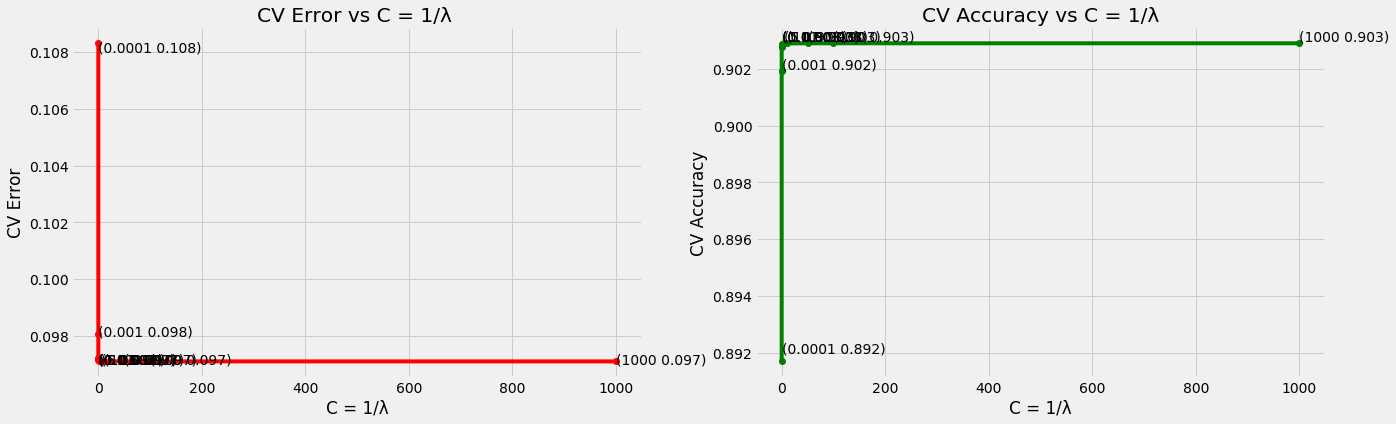


CV Error for each value of C:  [0.108 0.098 0.097 0.097 0.097 0.097 0.097 0.097 0.097 0.097]

CV Accuracy for each value of C:  [0.892 0.902 0.903 0.903 0.903 0.903 0.903 0.903 0.903 0.903]
CPU times: user 8min 2s, sys: 1.04 s, total: 8min 3s
Wall time: 8min


In [49]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_avgw2v_std, y_train, penalty = 'l2')

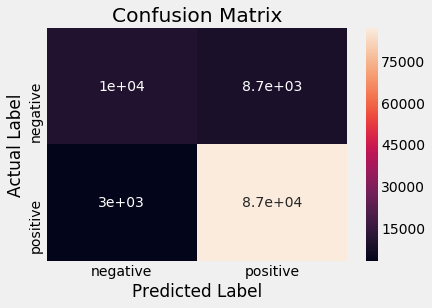

[[10342  8705]
 [ 3034 86999]]

Test Error : 0.108
Test Accuracy : 89.238 %
True Negative : 10342
False Positive : 8705
False Negative : 3034
True Positive : 86999
Precission Score : 0.841
Recall Score : 0.755
F1 Score : 0.787





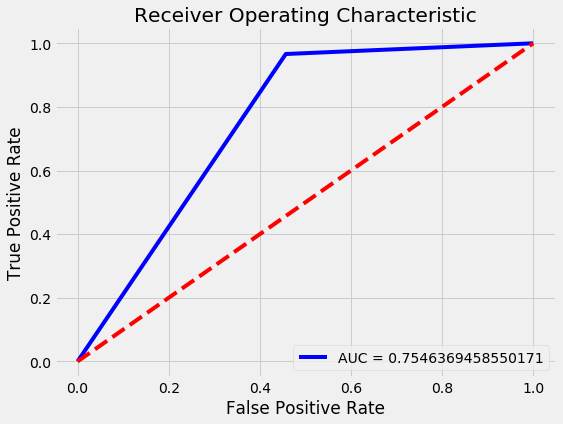

CPU times: user 7.46 s, sys: 12 ms, total: 7.47 s
Wall time: 7.03 s


In [50]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_avgw2v_std, X_test_avgw2v_std, y_train, y_test, 'l2', 50)

<b>L1 Regularization :</b>


Optimal C:  {'C': 1000}

CrossValidation Error: 0.097

CrossValidation Accuracy: 90.29 %




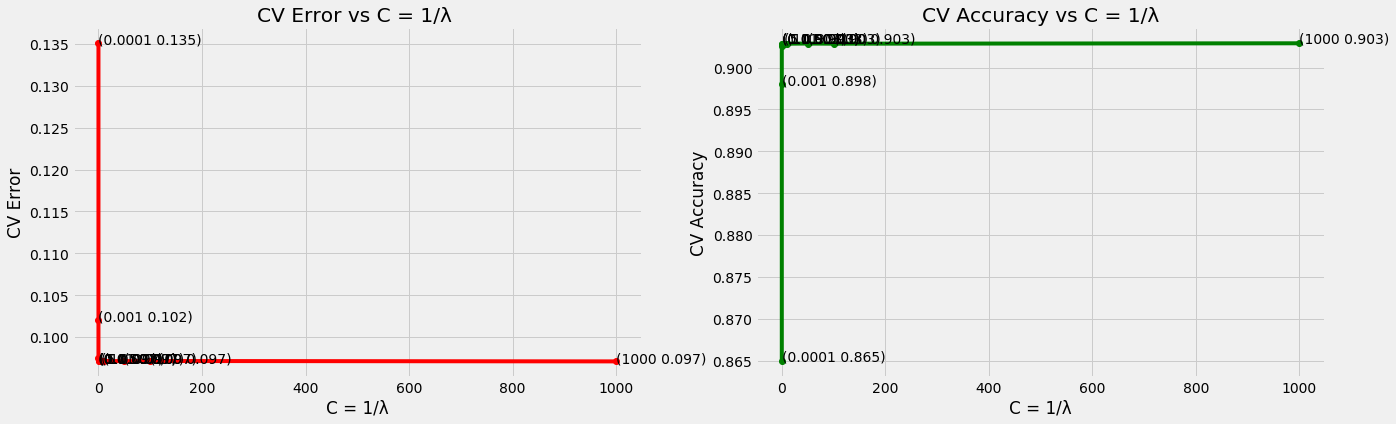


CV Error for each value of C:  [0.135 0.102 0.097 0.097 0.097 0.097 0.097 0.097 0.097 0.097]

CV Accuracy for each value of C:  [0.865 0.898 0.903 0.903 0.903 0.903 0.903 0.903 0.903 0.903]
CPU times: user 1h 35min 19s, sys: 3.26 s, total: 1h 35min 22s
Wall time: 1h 35min 19s


In [51]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_avgw2v_std, y_train, penalty = 'l1')

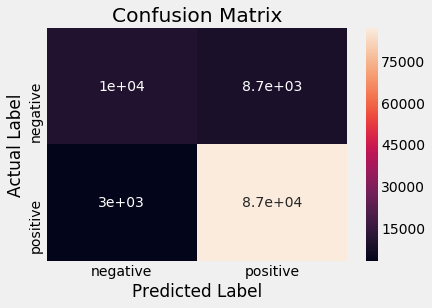

[[10345  8702]
 [ 3027 87006]]

Test Error : 0.108
Test Accuracy : 89.247 %
True Negative : 10345
False Positive : 8702
False Negative : 3027
True Positive : 87006
Precission Score : 0.841
Recall Score : 0.755
F1 Score : 0.788





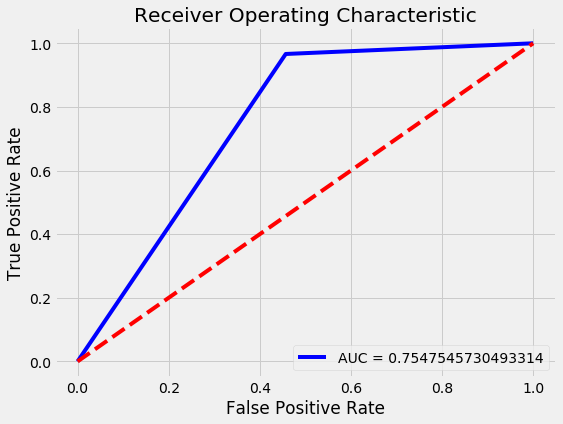

CPU times: user 2min 18s, sys: 44 ms, total: 2min 18s
Wall time: 2min 18s


In [53]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_avgw2v_std, X_test_avgw2v_std, y_train, y_test, 'l1',1000)

### [8.5.2] Sparsity And Accuracy on Weight Vectors(L1 Regularization) :

In [52]:
if __name__ == "__main__":
    sparsity_check(X_train_avgw2v_std, X_test_avgw2v_std ,y_train ,y_test)


Sparsity and Accuarcy when C = 10
Number of non-zero weighhts:  50
Train Error:  0.097
Test Error:  0.107
Test Accuracy : 0.89251
Run Time :77.11510200000066 sec

Sparsity and Accuarcy when C = 1
Number of non-zero weighhts:  50
Train Error:  0.097
Test Error:  0.107
Test Accuracy : 0.8925
Run Time :76.87039000000004 sec

Sparsity and Accuarcy when C = 0.1
Number of non-zero weighhts:  50
Train Error:  0.097
Test Error:  0.108
Test Accuracy : 0.89241
Run Time :93.50651099999959 sec

Sparsity and Accuarcy when C = 0.01
Number of non-zero weighhts:  49
Train Error:  0.097
Test Error:  0.108
Test Accuracy : 0.89203
Run Time :30.468505000000732 sec

Sparsity and Accuarcy when C = 0.001
Number of non-zero weighhts:  38
Train Error:  0.101
Test Error:  0.113
Test Accuracy : 0.88731
Run Time :4.664448999999877 sec

Sparsity and Accuarcy when C = 0.0001
Number of non-zero weighhts:  13
Train Error:  0.133
Test Error:  0.151
Test Accuracy : 0.84876
Run Time :1.6230040000009467 sec


<b>Observation :</b> Here C= 1/λ, we can see as C decreases(λ increases)
    -  Sparsity Increases(Number of non zero elements decreases)
    -  Error increases and Performance accuarcy drops(model starts underfitting)
    -  Run Time is also fast as sparsity increases

### [8.5.3] Using RandomSearch CV :
<b>L2 Regularization :</b>

In [54]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_avgw2v_std, y_train, penalty = 'l2')


Optimal C:  {'C': 2.6804844914828405}

CrossValidation Error: 0.097

CrossValidation Accuracy: 90.293 %


CPU times: user 8min 47s, sys: 1.09 s, total: 8min 48s
Wall time: 8min 45s


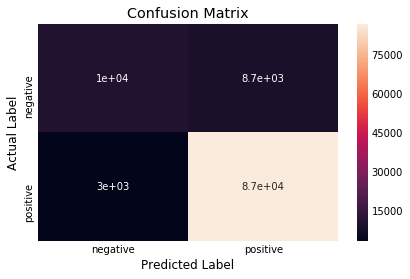

[[10345  8702]
 [ 3033 87000]]

Test Error : 0.108
Test Accuracy : 89.242 %
True Negative : 10345
False Positive : 8702
False Negative : 3033
True Positive : 87000
Precission Score : 0.841
Recall Score : 0.755
F1 Score : 0.787





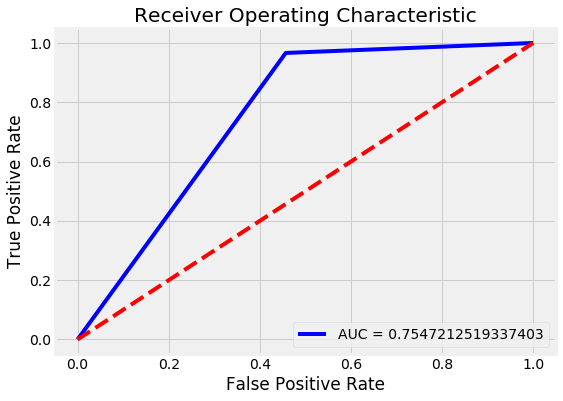

CPU times: user 10 s, sys: 4 ms, total: 10 s
Wall time: 9.58 s


In [72]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_avgw2v_std, X_test_avgw2v_std, y_train, y_test,'l2',2.680)

<b>L1 Regularization :</b>

In [ ]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_avgw2v_std, y_train, penalty = 'l1')


Optimal C:  {'C': 0.17690344265644772}

CrossValidation Error: 0.097

CrossValidation Accuracy: 90.288 %


CPU times: user 1h 53min 48s, sys: 5.83 s, total: 1h 53min 54s
Wall time: 1h 53min 51s


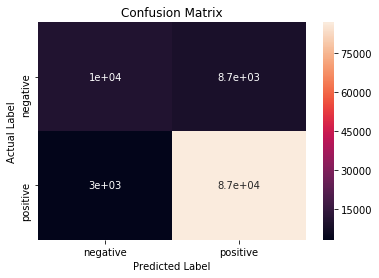

[[10327  8720]
 [ 3011 87022]]

Test Error : 0.108
Test Accuracy : 89.246 %
True Negative : 10327
False Positive : 8720
False Negative : 3011
True Positive : 87022
Precission Score : 0.842
Recall Score : 0.754
F1 Score : 0.787





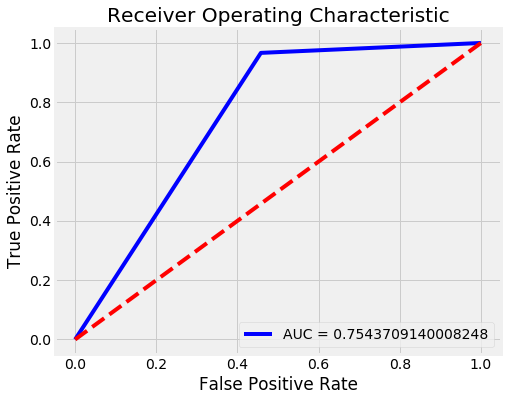

CPU times: user 1min 23s, sys: 148 ms, total: 1min 23s
Wall time: 1min 23s


In [15]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_avgw2v_std, X_test_avgw2v_std, y_train, y_test, 'l1', 0.176)

### [8.5.4] MultiCollinearity :

In [161]:
if __name__ == "__main__":
     multicollinear_check(X_train_avgw2v_std,X_test_avgw2v_std,y_train,y_test,50)

-----------BEFORE PERTUBATION TEST------------

Sample Weights:           0         1         2         3         4         5         6   \
0 -0.588587  0.446414 -0.533977 -0.788838 -0.422129 -0.363002  0.372933   

        7         8         9     ...           40       41        42  \
0  0.04856  0.144315 -0.020016    ...    -0.237664 -0.42991 -0.534093   

         43        44       45        46        47       48        49  
0 -0.174668 -0.363496  0.07075  0.365204 -0.169001 -0.25998 -0.458187  

[1 rows x 50 columns]
Size of weight vector:  50
Non zero weights:  50
Test Accuracy : 89.238 %

-----------AFTER PERTUBATION TEST------------

Sample Weights:           0        1         2         3        4         5        6   \
0 -0.576476  0.44317 -0.519533 -0.756785 -0.42583 -0.356126  0.35971   

         7         8         9     ...           40        41        42  \
0  0.046812  0.136165 -0.012172    ...    -0.227333 -0.428892 -0.525311   

         43        44        45    

## [8.6] TF-IDF Weighted Word2Vec : <a name="tfidfw2v"></a>

In [17]:
%%time
tfidf_feat = tfidf_bigram.get_feature_names() # tfidf words/col-names
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = X_train_tfidfbi[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

CPU times: user 29min 29s, sys: 876 ms, total: 29min 30s
Wall time: 29min 29s


In [37]:
%%time
X_test_tfidfw2v = [];
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = X_train_tfidfbi[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1

CPU times: user 12min 57s, sys: 2.1 s, total: 13min
Wall time: 12min 59s


In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfw2v_std = sc.fit_transform(X_train_tfidfw2v)

In [39]:
X_test_tfidfw2v_std = sc.transform(X_test_tfidfw2v)

In [40]:
print("Number of rows in Train Data: ",len(X_train_tfidfw2v_std))
print("Number of features in Train Data: ",len(X_train_tfidfw2v_std[0]))
print("Number of rows in Test Data: ",len(X_test_tfidfw2v_std))
print("Number of features in Test Data: ",len(X_test_tfidfw2v_std[0]))

Number of rows in Train Data:  254519
Number of features in Train Data:  50
Number of rows in Test Data:  109080
Number of features in Test Data:  50


In [41]:
dumpfile(X_train_tfidfw2v_std,"X_train_tfidfw2v_std")
dumpfile(X_test_tfidfw2v_std,"X_test_tfidfw2v_std")

### [8.6.1] Using GridSearch CV :
<b>L2 Regularization :</b>


Optimal C:  {'C': 0.0001}

CrossValidation Error: 0.149

CrossValidation Accuracy: 85.075 %




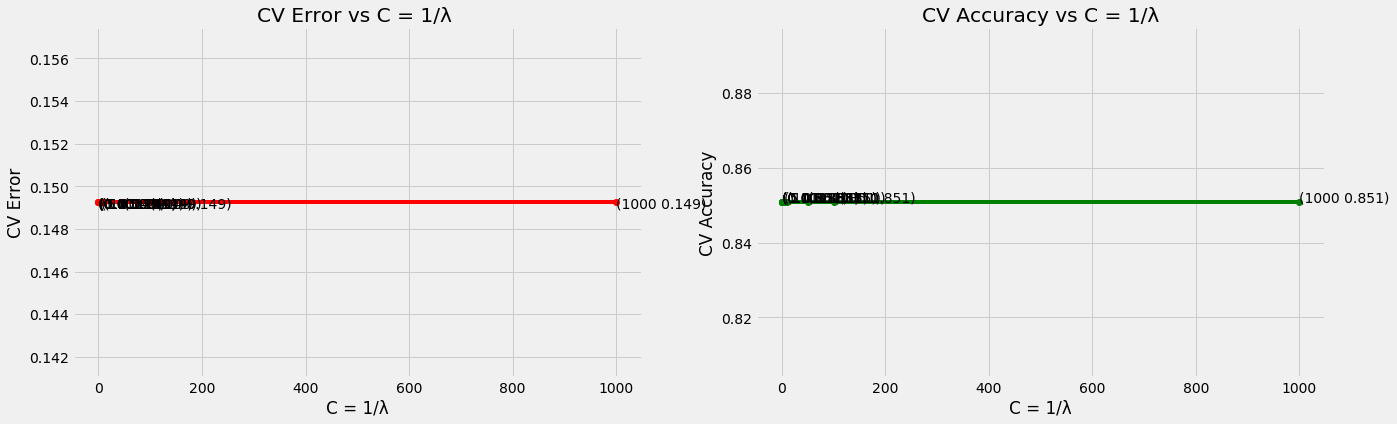


CV Error for each value of C:  [0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149]

CV Accuracy for each value of C:  [0.851 0.851 0.851 0.851 0.851 0.851 0.851 0.851 0.851 0.851]
CPU times: user 32.8 s, sys: 1.21 s, total: 34 s
Wall time: 30.9 s


In [42]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_tfidfw2v_std, y_train, penalty = 'l2')

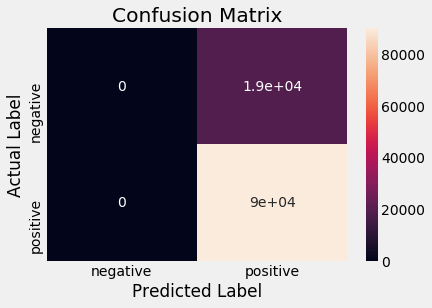

[[    0 19047]
 [    0 90033]]

Test Error : 0.175
Test Accuracy : 82.539 %
True Negative : 0
False Positive : 19047
False Negative : 0
True Positive : 90033
Precission Score : 0.413
Recall Score : 0.5
F1 Score : 0.452





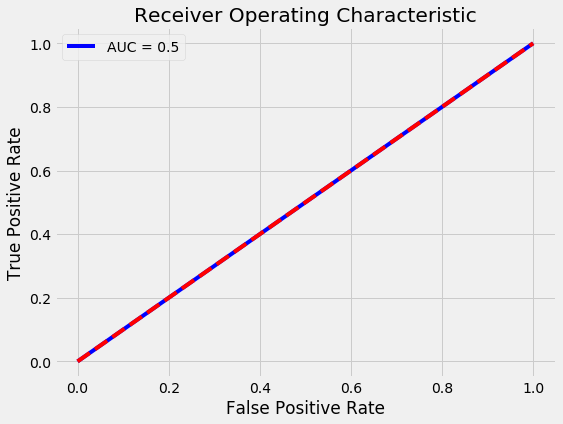

CPU times: user 1.41 s, sys: 8 ms, total: 1.42 s
Wall time: 990 ms


In [43]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfw2v_std, X_test_tfidfw2v_std, y_train, y_test, 'l2', 0.0001)

<b>L1 Regularization :</b>


Optimal C:  {'C': 0.0001}

CrossValidation Error: 0.149

CrossValidation Accuracy: 85.075 %




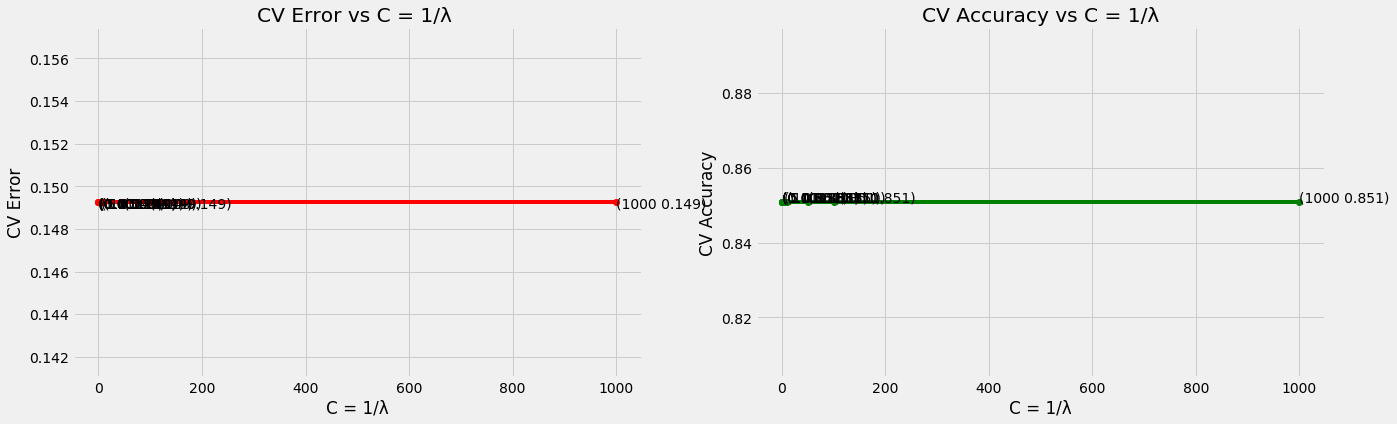


CV Error for each value of C:  [0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149 0.149]

CV Accuracy for each value of C:  [0.851 0.851 0.851 0.851 0.851 0.851 0.851 0.851 0.851 0.851]
CPU times: user 28.1 s, sys: 1.07 s, total: 29.2 s
Wall time: 25.7 s


In [47]:
%%time
if __name__ == "__main__":
    LR_gridTrain(X_train_tfidfw2v_std, y_train, penalty = 'l1')

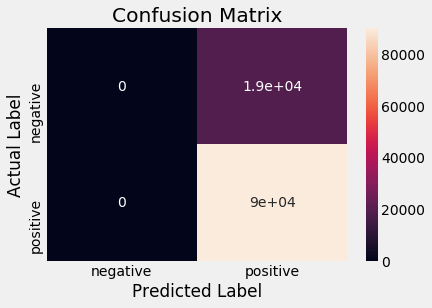

[[    0 19047]
 [    0 90033]]

Test Error : 0.175
Test Accuracy : 82.539 %
True Negative : 0
False Positive : 19047
False Negative : 0
True Positive : 90033
Precission Score : 0.413
Recall Score : 0.5
F1 Score : 0.452





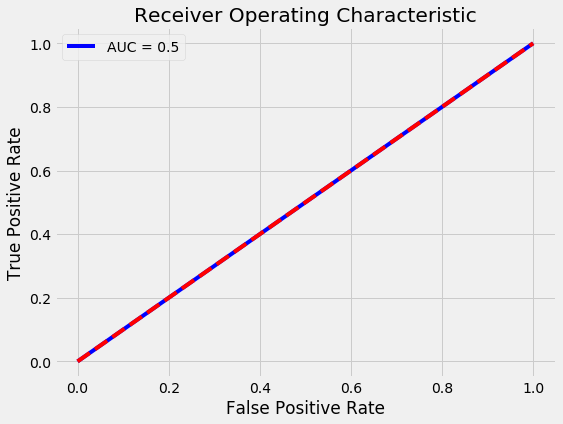

CPU times: user 1.34 s, sys: 28 ms, total: 1.36 s
Wall time: 962 ms


In [48]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfw2v_std, X_test_tfidfw2v_std, y_train, y_test, 'l1', 0.0001)

### [8.6.2] Sparsity And Accuracy on Weight Vectors(L1 Regularization) :

In [44]:
if __name__ == "__main__":
    sparsity_check(X_train_tfidfw2v_std, X_test_tfidfw2v_std ,y_train ,y_test)


Sparsity and Accuarcy when C = 10
Number of non-zero weighhts:  0
Train Error:  0.149
Test Error:  0.175
Test Accuracy : 0.82539
Run Time :0.4394509999992806 sec

Sparsity and Accuarcy when C = 1
Number of non-zero weighhts:  0
Train Error:  0.149
Test Error:  0.175
Test Accuracy : 0.82539
Run Time :0.4273480000001655 sec

Sparsity and Accuarcy when C = 0.1
Number of non-zero weighhts:  0
Train Error:  0.149
Test Error:  0.175
Test Accuracy : 0.82539
Run Time :0.4278549999999086 sec

Sparsity and Accuarcy when C = 0.01
Number of non-zero weighhts:  0
Train Error:  0.149
Test Error:  0.175
Test Accuracy : 0.82539
Run Time :0.4308789999995497 sec

Sparsity and Accuarcy when C = 0.001
Number of non-zero weighhts:  0
Train Error:  0.149
Test Error:  0.175
Test Accuracy : 0.82539
Run Time :0.4345000000002983 sec

Sparsity and Accuarcy when C = 0.0001
Number of non-zero weighhts:  0
Train Error:  0.149
Test Error:  0.175
Test Accuracy : 0.82539
Run Time :0.4260019999992437 sec


### [8.6.3] Using RandomSearch CV :
<b>L2 Regularization :</b>

In [45]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_tfidfw2v_std, y_train, penalty = 'l2')


Optimal C:  {'C': 1.2928165589093843}

CrossValidation Error: 0.149

CrossValidation Accuracy: 85.075 %


CPU times: user 32.4 s, sys: 980 ms, total: 33.4 s
Wall time: 30.2 s


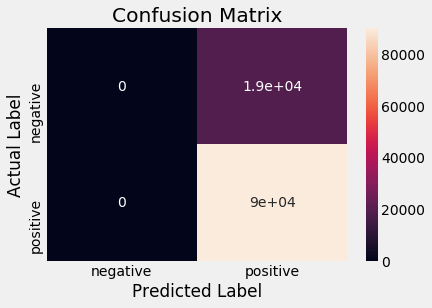

[[    0 19047]
 [    0 90033]]

Test Error : 0.175
Test Accuracy : 82.539 %
True Negative : 0
False Positive : 19047
False Negative : 0
True Positive : 90033
Precission Score : 0.413
Recall Score : 0.5
F1 Score : 0.452





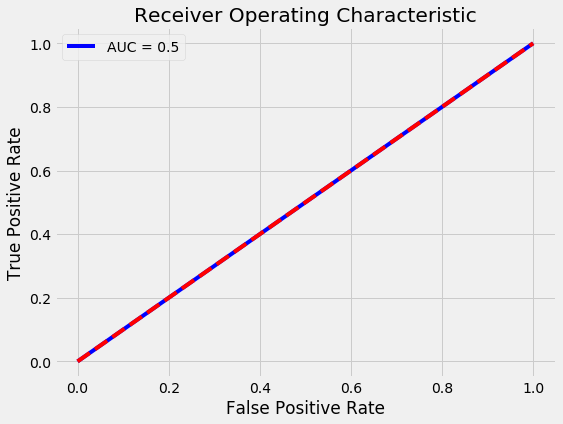

CPU times: user 1.36 s, sys: 8 ms, total: 1.36 s
Wall time: 981 ms


In [46]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfw2v_std, X_test_tfidfw2v_std, y_train, y_test, 'l2', 1.29)

<b>L1 Regularization :</b>

In [49]:
%%time
if __name__ == "__main__":
    LR_randomTrain(X_train_tfidfw2v_std, y_train, penalty = 'l1')


Optimal C:  {'C': 0.9964195542921448}

CrossValidation Error: 0.149

CrossValidation Accuracy: 85.075 %


CPU times: user 27.4 s, sys: 1.16 s, total: 28.5 s
Wall time: 25.4 s


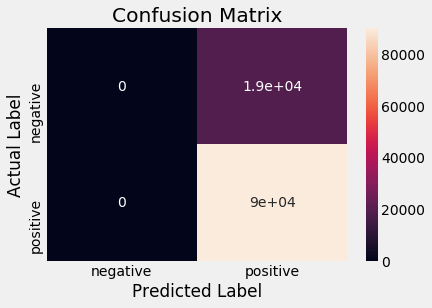

[[    0 19047]
 [    0 90033]]

Test Error : 0.175
Test Accuracy : 82.539 %
True Negative : 0
False Positive : 19047
False Negative : 0
True Positive : 90033
Precission Score : 0.413
Recall Score : 0.5
F1 Score : 0.452





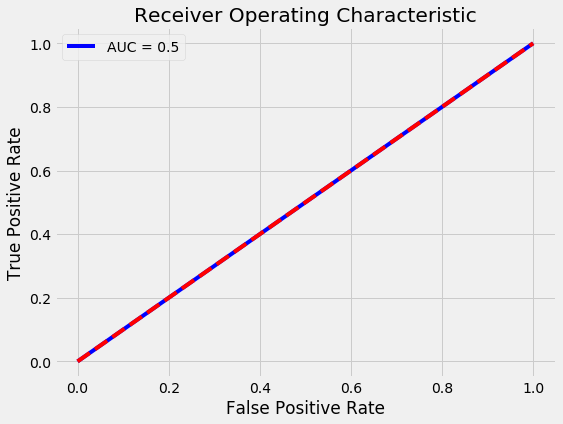

CPU times: user 1.34 s, sys: 28 ms, total: 1.37 s
Wall time: 954 ms


In [51]:
%%time
if __name__ == "__main__":
    LR_Test(X_train_tfidfw2v_std, X_test_tfidfw2v_std, y_train, y_test, 'l1', 0.99)

<b>Observation :</b> Tfidf Weighted Word2Vec classifies all the test data(unseen points) as Positive(majority class). It is like a dumb model as we can see from the ROC plot,it overlaps with simple model and True Negative is also zero.

## [9] Conclusion : <a name="conclusion"></a>

### Grid Search Cross Validation :

| Featurization Model | L2 Regularization |  |  |  |L1 Regularization |  |  |  |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| <b>BOW(unigram)</b> | 91.569 % | 0.878  | 0.813 | 0.84 | 91.548 % | 0.875  | 0.816 | 0.841 |
| <b>BOW(bigram)</b> | 93.004 % | 0.908  | 0.838 | 0.868 | 93.039 % | 0.905  | 0.843 | 0.87 |
| <b>TF-IDF(unigram)</b> | 91.823 % | 0.878  | 0.824 | 0.847 | 91.892 % | 0.877  | 0.828 | 0.85 |
| <b>TF-IDF(bigram)</b> | 93.166 % | 0.895  | 0.859 | 0.876 | 93.357 % | 0.906  | 0.855 | 0.877 |
| <b>Average Word2vec</b> | 89.238 % | 0.841  | 0.755 | 0.787 | 89.247 % | 0.841  | 0.755 | 0.788 |
| <b>TF-IDF Wweighted Word2Vec</b> | 82.539 % | 0.413  | 0.5 | 0.452 | 82.539 % | 0.413  | 0.5 | 0.452 |


<br>

### Random Search Cross Validation :

| Featurization Model | L2 Regularization |  |  |  | L1 Regularization |  |  |  |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| <b>BOW(unigram)</b> | 91.566 % | 0.874  | 0.817 | 0.842 | 91.563 % | 0.875  | 0.817 | 0.842 |
| <b>BOW(bigram)</b> | 92.794 % | 0.886  | 0.856 | 0.87 | 92.92 % | 0.89  | 0.856 | 0.872 |
| <b>TF-IDF(unigram)</b> | 91.859 % | 0.876  | 0.828 | 0.849 | 91.915 % | 0.881  | 0.824 | 0.849 |
| <b>TF-IDF(bigram)</b> | 92.999 % | 0.889  | 0.861 | 0.874 | 93.342 % | 0.901  | 0.859 | 0.878 |
| <b>Average Word2vec</b> | 89.242 % | 0.841  | 0.755 | 0.787 | 89.246 % | 0.842  | 0.754 | 0.787 |
| <b>TF-IDF Wweighted Word2Vec</b> | 82.539 % | 0.413  | 0.5 | 0.452 | 82.539 % | 0.413  | 0.5 | 0.452 |


<br>
<b>1</b> - <b>Tfidf with bigram</b> performed the <b>best</b> with all performance metrics having an <b>accuracy of 93.166 % and F1 Score of .876 in L2 regularization, accuracy of 93.357 % and F1 Score of .877 in L1 regularization</b>.  

<b>2</b> - Both Gridserach and Random Search Crossvalidation gave almost equal results.  

<b>3</b> - <b>L1 regularization</b> creates a <b>sparse weight vector</b> ie all the less impoartant features becomes zero.  

<b>4</b> - It is also observed that in <b>L1 regularization, as hyperparameter C decreases(lambda increases)</b>,  
&emsp; (i) Sparsity Increases(Number of non zero elements decreases)  
&emsp; (ii)Error increases and Performance accuarcy drops(model starts underfitting)  
&emsp; (iii)Run Time is also fast as sparsity increases  

<b>5</b> - Logistic Regression gave better accuracies and results as compared to Naive Bayes model.  

<b>6</b> - <b>Run Time Complexity</b> of Logistic Regression is less. This model can be used for <b>low latency applications</b>.   

<b>7</b> - <b>TF-IDF Wweighted Word2Vec performed worst</b> in Logistic Regression model. It is like a <b>dumb model</b> as every unseen points gets classified as majority class(Positive).

          